<a href="https://colab.research.google.com/github/ArthurNazarenko/nebius_academy_practice/blob/main/topic2/2.7_agentic_orchestration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Engineering Essentials by Nebius Academy

Course github: [link](https://github.com/Nebius-Academy/LLM-Engineering-Essentials/tree/main)

The course is in development now, with more materials coming soon. [Subscribe to stay updated](https://academy.nebius.com/llm-engineering-essentials/update/)

# 2.7. Agentic Orchestration

In this notebook, we'll continue exploring LLM Agents, but this time we'll unlock their more advanced capabilities: planning and intra-agent interaction.

## Setting things up

In [1]:
!pip install -q openai

In [2]:

import os
from google.colab import userdata
nebius_api_key=userdata.get('nebius_api_key')
os.environ["NEBIUS_API_KEY"] = nebius_api_key

In [3]:
from openai import OpenAI
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)
model = "meta-llama/Meta-Llama-3.1-70B-Instruct"

# Part 1: Agentic Workflows

We already know that an LLM can use tools, making it a powerful agent. However, in our last discussion, we only allowed LLMs to use tools to assist in answering users' questions. But agents can do much more than that! LLM agents can function as autonomous "workers," capable of performing multi-step tasks.  

For example, if you have a GitHub issue, an agent might attempt to fix it by iterating through multiple attempts, refining its solutions until the goals are met. And that's not sci-fi! [SWE-Agent](https://github.com/SWE-agent/SWE-agent), developed and maintained by researchers from Princeton University and Stanford University, is a real-world example of such an agent.  

Let's explore how these agents work.  

## An Agent and an Environment

In general, an autonomous **agent** interacts with an **environment** as follows:  

- The environment provides the agent with **observations** of its **state**.  
- The agent can take **actions** that affect the environment.  
- After each action, the agent receives new **observations**, which may include **state changes** and **rewards**.  

<center>  
<img src="https://drive.google.com/uc?export=view&id=1QRQwtYHUe-5Q4ms9Mq_px8tG4hHeU26A" width=600 />  
</center>  

If this structure reminds you of **Reinforcement Learning** (RL), you're absolutely right! In fact, RL operates within an agentic framework, but instead of explicit training, LLMs rely on **in-context learning** - leveraging prior information about agent-environment interactions embedded in prompts.  

**Note:** In more advanced frameworks, an LLM functioning as part of an agent can also undergo training, making the entire system a true example of RL. The RL training of LLM Agents can be facilitated by Meta’s [MLGym framework](https://github.com/facebookresearch/MLGym), a conceptual successor to [gym](https://github.com/openai/gym), which helped many ML students learn RL by training models on Atari games and similar environments.  

## The ReACT agentic framework

The **ReAct** (Reason + Act) framework is a straightforward implementation of the agent-environment interaction concept. ReACT was introduced in the ReACT: [Synergizing reasoning and acting in language models paper](https://arxiv.org/pdf/2210.03629)  in March '23 and remains popular to this day.

A ReAct LLM agent alternates between the following stages:

- **Observation**: this may be analysis of the user input, tool output, and so on.
- **Reasoning**: this may involve deciding which tool to use, the arguments to provide, or making the decision that the LLM is able to independently answer.
- **Action**: this could be invoking particular tools or sending the final output to the user.

Here are some examples from the original paper:

<center>
<img src="https://drive.google.com/uc?export=view&id=1DtGrd-5cALY--bPl0905NR78VuBBTLqL" width=600 />
</center>

ReACT is quite basic, and more advanced frameworks were suggested, such as RAISE.

## RAISE: Reasoning and Acting through Scratchpad and Examples

<center>
<img src="https://drive.google.com/uc?export=view&id=1L8gBH5b2msNKP_cRJIenNgc81Fi5TScd" width=800 />
</center>

**RAISE** (introduced in [this paper](https://arxiv.org/pdf/2401.02777)) is a framework that is quite comprehensive, incorporating a large variety of components:

- A database of examples to use
- Tools, including a retrieval tool for the example database
- A scratchpad for covert reasoning and action planning
- Role-assigning system prompt
- Chat memory containing conversation history (which can also be packed into a database for RAG)
- A controller to rule them all

It can give you an feeling of how complex an agent may be.

An important addition here is the dedicated memory allowing the agent to “learn on its experience”.

# Building a ReACT-type agent

It's practice time, and we'll start by defining the environment.

## The environment: Dungeon Navigation Challenge

**Overview**

This environment models a series of interconnected **rooms** containing **keys** and **doors**, which may be **locked** or unlocked. An AI agent must navigate through rooms, collect keys, and unlock doors to reach a target room containing a priceless artifact.

**Environment Properties**

- Partially observable (agent only knows what it has explored)
- At every given moment, the agent is located in a specific room
- Multiple doors may connect the same two rooms
- Not all keys have matching doors, and not all locked doors have keys; but only one key may fit each door
- Each room, door, and key has both an ID and a descriptive text

**Agent API**

The environment offers several functions for the agent to use:

- `move(door_id)`: Attempt to pass through a door in a room where the agent is located. Fails if the door is locked, or if the agent is in a different room, or if the room's ID is incorrect
- `search_for_keys()`: Search current room for keys. It retrieves all the keys available in the room; second attempt at searching reveals nothing new
- `try_unlock(door_id, key_id)`: Attempt to unlock a door in the room, where the agent is located, with a specific key. Fails if the key doesn't fit the door, or if the door isn't in the same room with the agent, or if the agent doesn't possess the key, or if one of the IDs is invalid.

**Objective**

The agent succeeds when it reaches the target room containing the artifact

Let's create a dungeon navigation environment and experiment with it.

We have all the necessary code in the `dungeon_navigation.py` file which we'll download from the course's github:

In [4]:
!curl -o dungeon_navigation.py https://raw.githubusercontent.com/Nebius-Academy/LLM-Engineering-Essentials/main/topic2/dungeon_navigation.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39633  100 39633    0     0   122k      0 --:--:-- --:--:-- --:--:--  122k


Particular environments (dungeons) may be created using the `EnvironmentFactory` class. We provide three basic dungeons:

* `EnvironmentFactory.create_complex_environment()`
* `EnvironmentFactory.create_medium_environment()`
* `EnvironmentFactory.create_complex_environment()`

There's also a `EnvironmentFactory.create_custom_environment()`, but right now it tends to create rather simple dungeons.

See the examples below.

We also provide the `visualize_environment` function. It plots a dungeon as a graph with:

* Each node is a **room**, marked with `node_id [key_id1, key_id2,...]` showing which keys may be found in the room
* Each edge is a **door**. It's drawn as a solid line marked with `door_id []`, if the door is unlocked; otherwise it's a dashed line marked with `door_id [key_id]`
* The starting node is <font color="red">red</font> and the target node is <font color="green">green</font>.

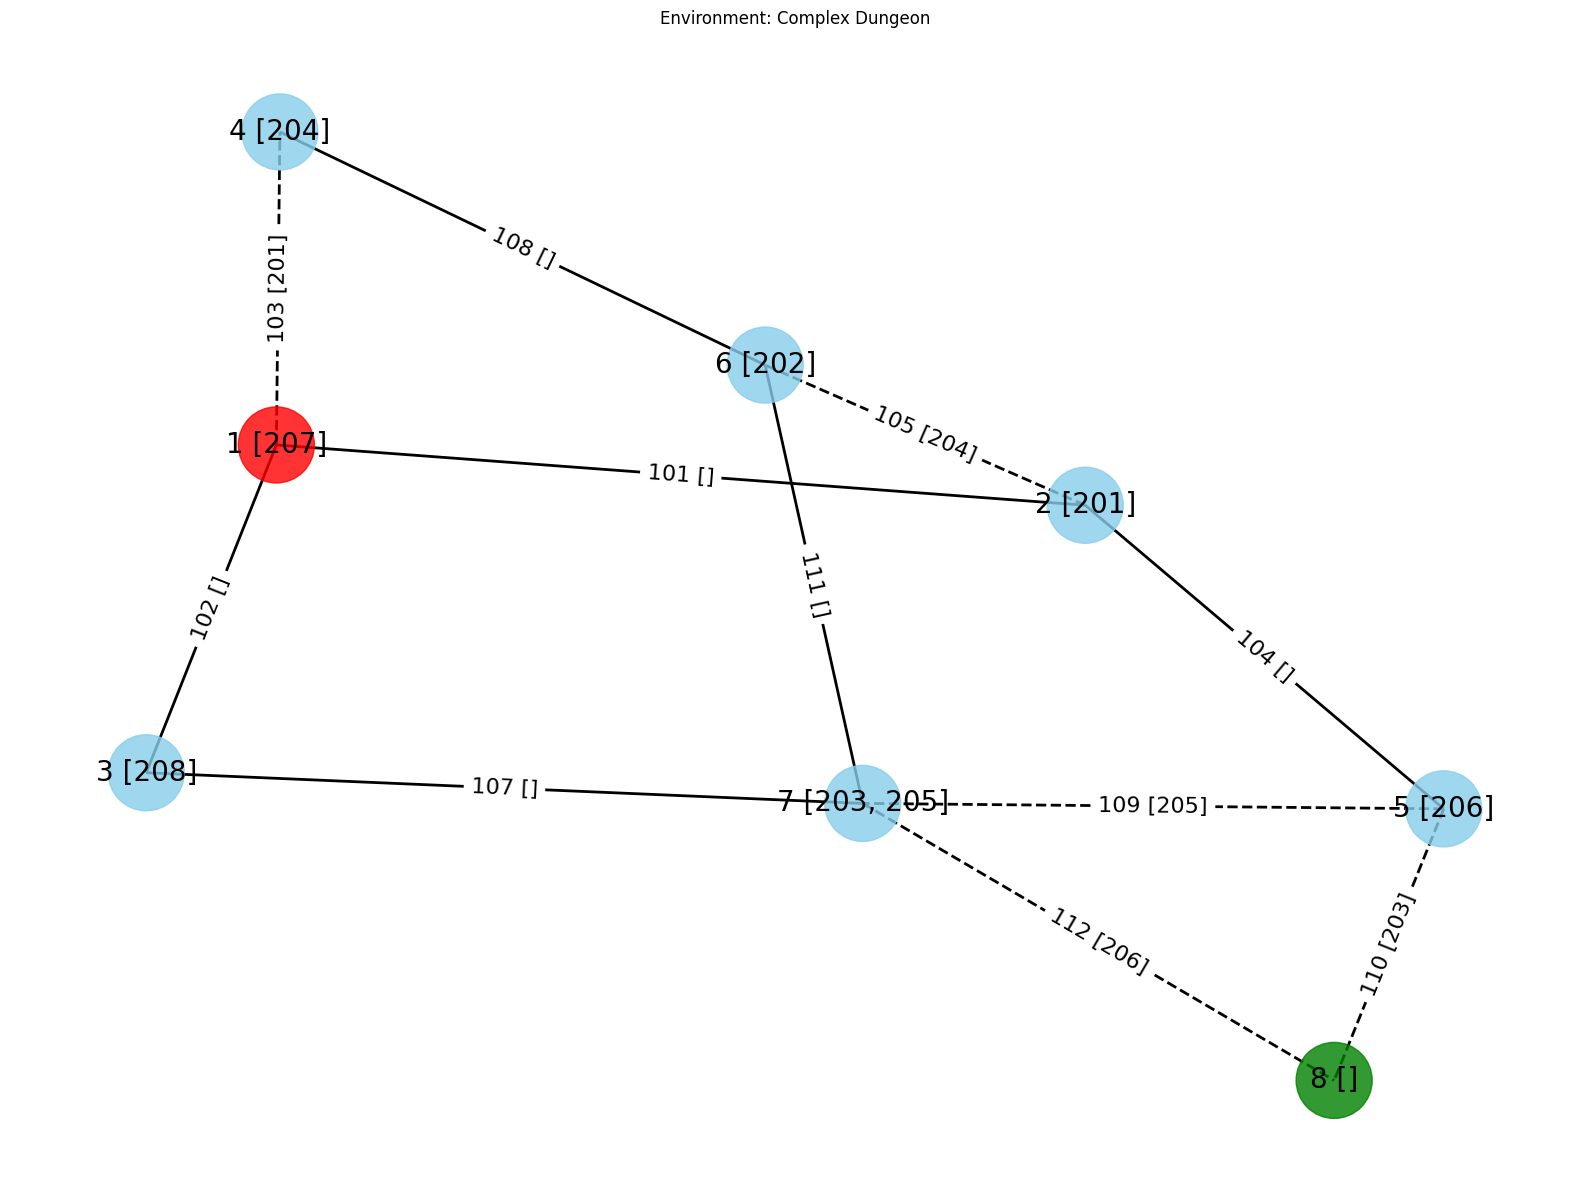

In [5]:
from dungeon_navigation import EnvironmentFactory, visualize_environment

# Create a custom environment
env = EnvironmentFactory.create_complex_environment()

# Visualize it
visualize_environment(env, "environment_visualization.png")

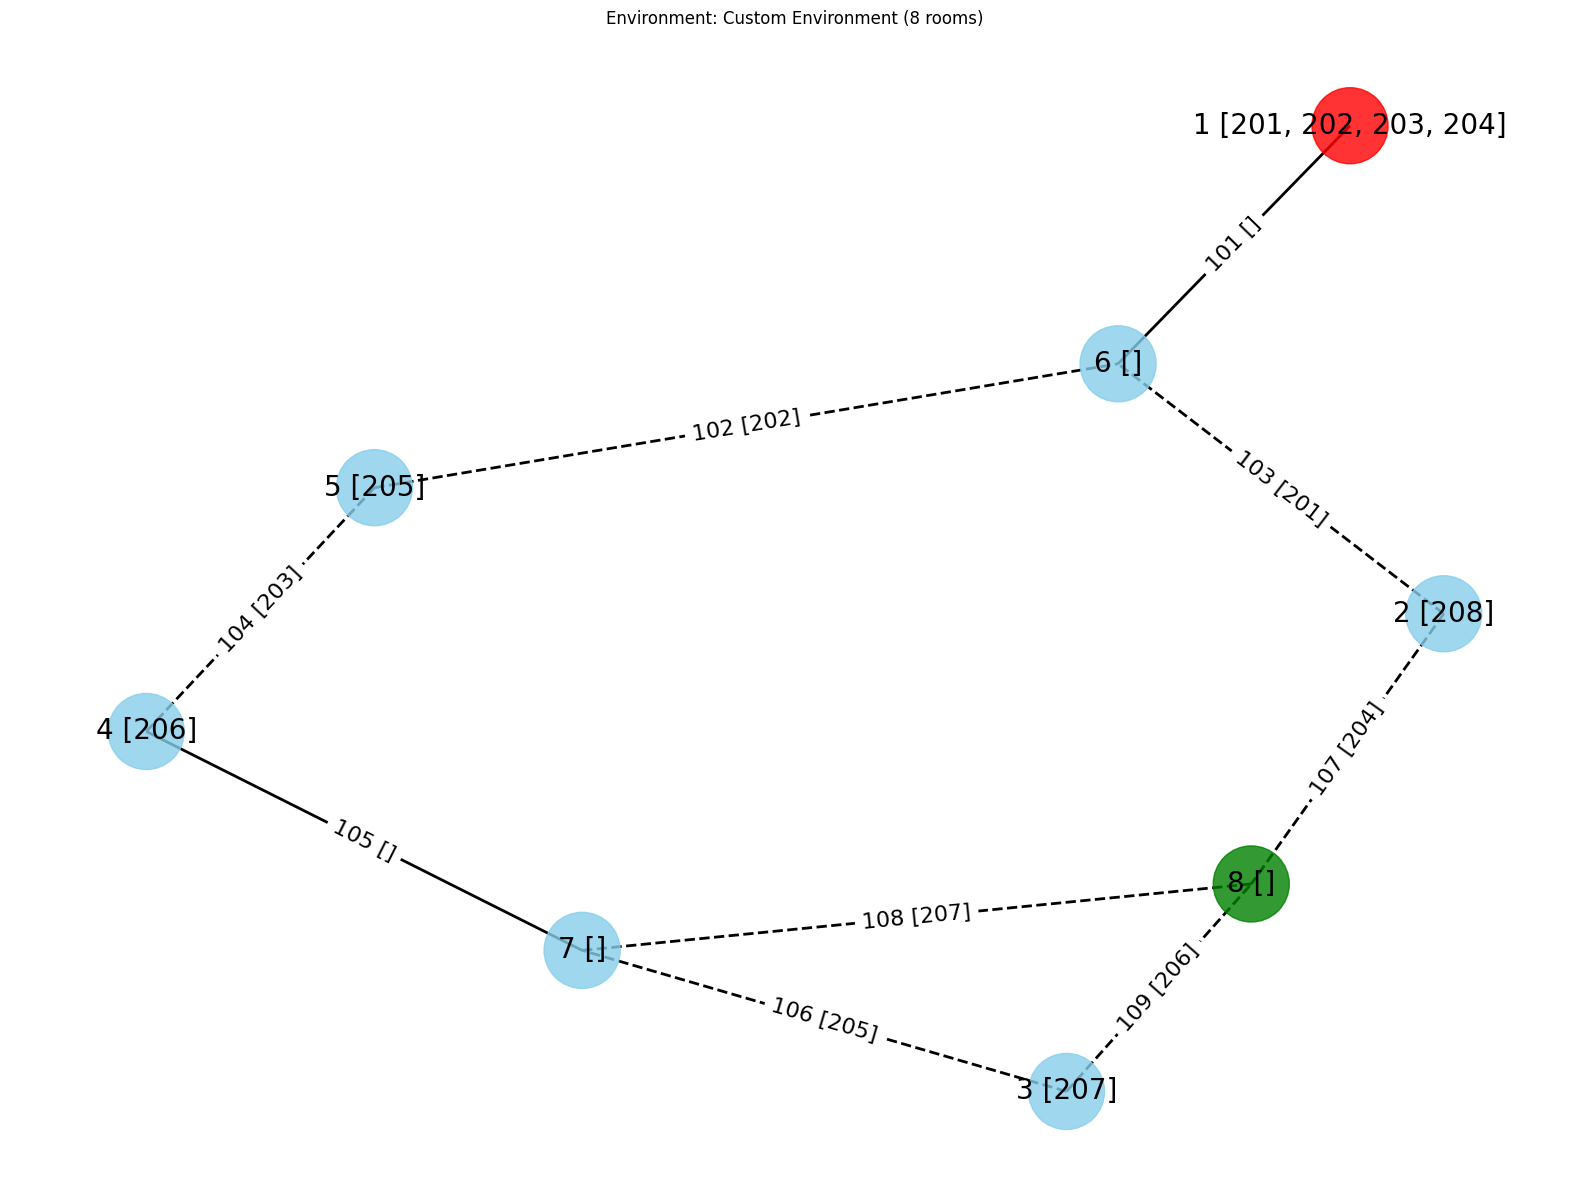

In [6]:
# Create a medium complexity environment
env = EnvironmentFactory.create_custom_environment(
        num_rooms=8,
        num_doors=9,
        lock_percentage=0.75,
        red_herring_keys=1
        )

# Visualize it
visualize_environment(env, "environment_visualization.png")

## Implementing a ReACT agent

Now we're ready to create an agent for our Dungeon Navigation Challenge.

Its main components will be:

* A set of **tools**: `move`, `search_for_keys`, and `try_unlock` to interact with the environment, and also a `plan` tool for **planning the next step**.

  The planning is just another LLM call with a specific prompt.

  Tools are chosen by the LLM; the only thing we did is gently encouraging it towards not to overindulge in planning by the

  ```
  If you did planning on the previous step, use some real action now.
  Don't fall victim to analysis paralysis!
  ```

  line in a prompt.

* **Working memory**, which is a string, produced by yet another LLM call based on the recent interactions with the environment and pervious memory state. We let the LLM decide itself how to structure its memory.

  The function `_update_memory_after_action` is called after each interaction with the environment.

The agent works in a loop, which terminates when either victory is achieved or `max_steps` is reached.

<center>
<img src="https://drive.google.com/uc?export=view&id=1or9xasKOK_qMEe6msW1Hrg63JUPFcUoa" width=600 />
</center>

In [7]:
import json
from typing import Dict, List, Any, Optional, Tuple


class ReACTAgent:
    """
    A ReACT-type agent for navigating the room environment.

    This agent uses an LLM to decide actions, maintains a string-based memory,
    and executes tools to interact with the environment.
    """

    def __init__(self, environment, client, model, verbose=False, max_steps=100):
        """
        Initialize the ReACT agent.

        Args:
            environment: The room navigation environment
            client: The LLM client (e.g., Nebius, OpenAI)
            model: The model to use
            verbose: Whether to print detailed logs
            max_steps: Maximum number of steps before stopping
        """
        self.env = environment
        self.client = client
        self.model = model
        self.verbose = verbose
        self.max_steps = max_steps

        # Initialize state
        self.agent_id = "react_agent"
        self.memory = ""
        self.history = []
        self.step_count = 0
        self.is_victory = False

        # Define tools
        self.tools = [
            {
                "type": "function",
                "function": {
                    "name": "move",
                    "description": "Move through a door to another room. The door must be unlocked.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "door_id": {
                                "type": "number",
                                "description": "The ID of the door to move through. Make sure to use a correct door ID"
                            }
                        },
                        "required": ["door_id"]
                    }
                }
            },
            {
                "type": "function",
                "function": {
                    "name": "search_for_keys",
                    "description": "Search the current room for keys.",
                    "parameters": {
                        "type": "object",
                        "properties": {},
                        "required": []
                    }
                }
            },
            {
                "type": "function",
                "function": {
                    "name": "try_unlock",
                    "description": "Try to unlock a door with a specific key.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "door_id": {
                                "type": "number",
                                "description": "The ID of the door to unlock. Make sure to use a correct door ID"
                            },
                            "key_id": {
                                "type": "number",
                                "description": "The ID of the key to use. Make sure to use a correct key ID"
                            }
                        },
                        "required": ["door_id", "key_id"]
                    }
                }
            },
            {
                "type": "function",
                "function": {
                    "name": "plan",
                    "description": """
Think about the current situation and plan next steps. Use this for reasoning and planning without taking action.
You avoid using planning two times in a row. Instead, after each planning session, you make some real action.""",
                    "parameters": {
                        "type": "object",
                        "properties": {},
                        "required": []
                    }
                }
            }
        ]

        self.environment_description = """
## Environment:
- The environment consists of interconnected rooms
- Rooms are connected by doors, which may be locked or unlocked
- When in a room, you are always aware, which doors this room has and which of them are locked or unlocked
- Keys are scattered throughout rooms and can unlock specific doors
- In a room where you are at the moment, you can try searching for keys. A search gives you all available keys at once. Another search won't give new keys
- To unlock a door, you need to be in a room with this door.
  You can try one of the keys you have. One of them may fit the door.
  However, there is a possibility that no keys that you have at the moment fit the door

## Your Goal:
- Navigate to the target room containing the artifact
  It is guaranteed that the room is reachable
- You'll need to explore rooms, collect keys, and unlock doors
- Not all keys have matching doors, and some locked doors may not have keys
"""

        # Environment tools that should trigger memory updates
        self.env_tools = ["move", "search_for_keys", "try_unlock"]

    def run(self):
        """Run the agent until victory or max steps is reached."""
        # Get initial observation
        initial_observation = self.env.initialize_agent(self.agent_id)
        self._log(f"Initial observation: {initial_observation}")

        # Add initial observation to history
        self.history.append({
            "step": 0,
            "tool": "initialize",
            "args": {},
            "result": initial_observation
        })

        # Run until victory or max steps
        while not self.is_victory and self.step_count < self.max_steps:
            result = self.step()

            if result.get("victory", False):
                self.is_victory = True
                self._log(f"Victory achieved in {self.step_count} steps!")
                break

        if not self.is_victory:
            self._log(f"Failed to achieve victory in {self.max_steps} steps.")

        return {
            "victory": self.is_victory,
            "steps": self.step_count,
            "memory": self.memory,
            "history": self.history
        }

    def step(self):
        """
        Execute one step of the agent's decision-making process.

        Returns:
            Dictionary containing result of the action
        """
        self.step_count += 1
        self._log(f"\n--- Step {self.step_count} ---")

        # Format prompt with current state and history
        prompt = self.format_prompt()

        # Get LLM response with tool calls
        response = self._call_llm(prompt)

        # Process tool calls from the LLM response
        tool_name, tool_args, result = self.process_tool_calls(response)

        # Add to history
        self.history.append({
            "step": self.step_count,
            "tool": tool_name,
            "args": tool_args,
            "result": result
        })

        # If an environment tool was used (not plan), prompt for memory update
        if tool_name in self.env_tools:
            self._update_memory_after_action(tool_name, tool_args, result)

        return result

    def _update_memory_after_action(self, tool_name, tool_args, result):
        """
        Update memory after an environment action by prompting the LLM.

        Args:
            tool_name: The tool that was used
            tool_args: Arguments to the tool
            result: Result of the tool execution
        """
        self._log("Updating memory after action...")

        # Format prompt for memory update
        update_messages = [
            {
                "role": "system",
                "content": """
You are helping an intelligent agent update its memory after taking an action.
Given the action taken, the result, and the current memory, update the agent's memory.
Your task is to integrate the new information with the existing memory.
Be concise but thorough in what you include in the memory.
Focus on what's important for future decision-making.
"""
            },
            {
                "role": "user",
                "content": f"""
## Action Taken:
Tool: {tool_name}
Arguments: {json.dumps(tool_args, indent=2)}

## Action Result:
```
{json.dumps(result, indent=2)}
```

## Current Memory:
```
{self.memory}
```

Please provide an updated memory that incorporates this new information.
"""
            }
        ]

        # Call LLM for memory update
        update_response = self.client.chat.completions.create(
            model=self.model,
            messages=update_messages,
            temperature=0.2
        )

        # Extract the updated memory
        new_memory = update_response.choices[0].message.content

        # Update the memory
        self.memory = new_memory
        self._log(f"Memory updated: {self.memory[:100]}...")

    def format_prompt(self):
        """
        Format the prompt for the LLM with current state and history.

        Returns:
            List of messages for the LLM
        """
        # System message with environment explanation and task
        system_message = {
            "role": "system",
            "content": f"""
You are an intelligent agent navigating through a series of interconnected rooms. Your task is to find a priceless artifact located in a target room.

{self.environment_description}
"""
        }

        # User message with current memory and history
        user_message = {
            "role": "user",
            "content": f"""
## Your Memory:
```
{self.memory}
```

## Action History:
```
{self._format_history()}
```

What will you do next? Choose ONE tool to use.
If you did planning on the previous step, use some real action now.
Don't fall victim to analysis paralysis!
"""
        }

        return [system_message, user_message]

    def _format_history(self):
        """Format the action history as a string."""
        if not self.history:
            return "No actions taken yet."

        history_str = ""
        for entry in self.history[-10:]:  # Only show the last 10 actions to avoid overloading
            history_str += f"Step {entry['step']}: Used tool '{entry['tool']}'"

            # Add arguments if not a plan
            if entry['tool'] != "plan" and entry['args']:
                history_str += f" with args {json.dumps(entry['args'])}"
            history_str += "\n"

            # Add thought for plan or result for other tools
            if entry['tool'] == "plan":
                history_str += f"Thought: {entry['result'].get('thought', '')[:200]}...\n"
            else:
                history_str += f"Result: {json.dumps(entry['result'], indent=2)}\n"

            history_str += "\n"

        return history_str

    def process_tool_calls(self, response):
        """
        Process tool calls from the LLM response.

        Args:
            response: The LLM response object

        Returns:
            Tuple of (tool_name, tool_args, result)
        """
        message = response.choices[0].message

        # Check if a tool was called
        if hasattr(message, 'tool_calls') and message.tool_calls:
            tool_call = message.tool_calls[0]  # Take the first tool call
            function_name = tool_call.function.name

            try:
                function_args = json.loads(tool_call.function.arguments)
            except json.JSONDecodeError:
                self._log(f"Error parsing arguments: {tool_call.function.arguments}")
                function_args = {}

            self._log(f"Processing tool call: {function_name}, args: {function_args}")

            # Handle the tool call
            if function_name == "plan":
                # Call the plan tool
                result = self._tool_plan()
                self._log(f"Planning result: {result['thought']}...")
                return function_name, function_args, result

            elif function_name in self.env_tools:
                # Call the environment method dynamically
                result = self._call_env_method(function_name, function_args)
                self._log(f"Environment tool result: {result}")
                return function_name, function_args, result

            else:
                self._log(f"Unknown function: {function_name}")
                return "unknown", function_args, {"success": False, "message": f"Unknown tool: {function_name}"}

        # If no tool call was found, default to plan
        self._log(f"No tool call found, defaulting to plan")
        result = self._tool_plan()
        self._log(f"Planning result: {result['thought'][:100]}...")
        return "plan", {}, result

    def _call_env_method(self, method_name, args):
        """
        Dynamically call an environment method with the right arguments.

        Args:
            method_name: Name of the environment method to call
            args: Arguments to pass to the method

        Returns:
            Result of the environment method call
        """
        try:
            # Get the method from the environment
            env_method = getattr(self.env, method_name)

            # Call the method with the agent_id as the first argument and the rest from args
            return env_method(self.agent_id, **args)

        except Exception as e:
            self._log(f"Error calling environment method: {e}")
            return {"success": False, "message": f"Error: {str(e)}"}

    def _tool_plan(self):
        """
        Tool implementation for plan. This calls the LLM to generate a planning thought.

        Returns:
            Result containing the planning thought
        """
        self._log("Executing planning step...")

        # Create a special prompt for planning
        plan_messages = [
            {
                "role": "system",
                "content": f"""
You are helping an agent plan its next steps in a room navigation challenge.
Given the recent history and memory, think deeply about the situation and create a plan of the next step.

Here is the description of the environment as it was explained to the agent:

{self.environment_description}

==End of description==

Be thorough but concise in your thinking.
"""
            },
            {
                "role": "user",
                "content": f"""
## Recent History:
```
{self._format_history()}
```

## Your Memory:
```
{self.memory}
```

Please think through the current situation and develop a plan.
"""
            }
        ]

        # Call LLM to generate a planning thought
        plan_response = self.client.chat.completions.create(
            model=self.model,
            messages=plan_messages,
            temperature=0.3
        )

        # Extract the planning thought
        thought = plan_response.choices[0].message.content

        return {
            "success": True,
            "message": "Planning complete",
            "thought": thought
        }

    def _call_llm(self, messages):
        """
        Call the LLM with the given messages.

        Args:
            messages: List of message dictionaries

        Returns:
            LLM response object
        """
        self._log("Calling LLM...")

        response = self.client.chat.completions.create(
            model=self.model,
            messages=messages,
            temperature=0.2,
            tools=self.tools,
            tool_choice="auto"
        )

        return response

    def _log(self, message):
        """Log a message if verbose is enabled."""
        if self.verbose:
            print(message)




Now, let's try to navigate several simple dungeons.

In [8]:
import os
from openai import OpenAI

client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY")
)

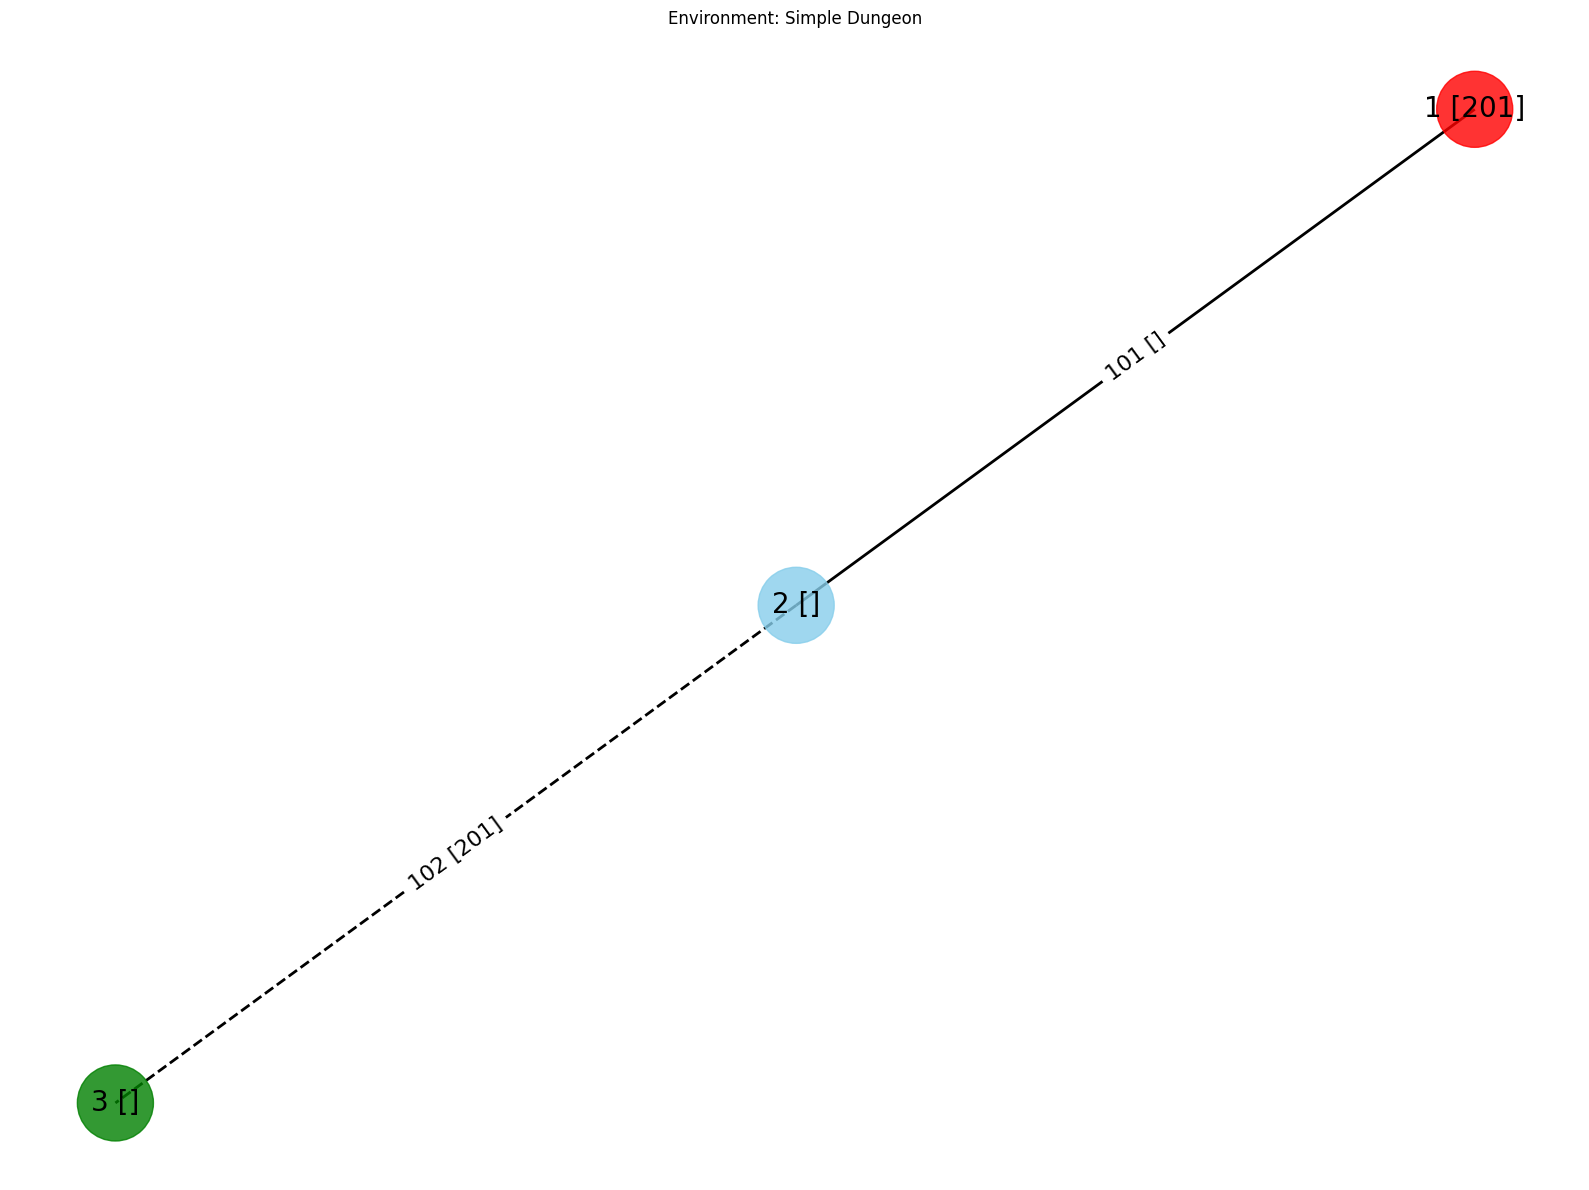

In [9]:
# Create a medium complexity environment
env = EnvironmentFactory.create_simple_environment()

# Visualize it
visualize_environment(env, "environment_visualization.png")

In [10]:
# Create agent
agent = ReACTAgent(
    environment=env,
    client=client,
    model="meta-llama/Meta-Llama-3.1-70B-Instruct",
    verbose=True,
    max_steps=30
)

# Run agent
result = agent.run()
print(f"\nFinal result: {result['victory']}, steps: {result['steps']}")

Initial observation: {'room_id': 1, 'room_description': 'A small, dimly lit chamber with stone walls. Dust motes dance in the air, and cobwebs adorn the corners.', 'doors': [{'id': 101, 'description': 'A wooden door with iron bands. It looks sturdy but not locked.', 'locked': False}]}

--- Step 1 ---
Calling LLM...
Processing tool call: move, args: {'door_id': '101'}
Environment tool result: {'success': True, 'victory': False, 'message': 'You moved through the door successfully.', 'room_id': 2, 'room_description': 'A circular room with a high domed ceiling. Ancient symbols are carved into the floor, glowing with a faint blue light.', 'doors': [{'id': 101, 'description': 'A wooden door with iron bands. It looks sturdy but not locked.', 'locked': False}, {'id': 102, 'description': 'A heavy stone door with intricate carvings of serpents. A keyhole shaped like a crescent moon is visible.', 'locked': True}]}
Updating memory after action...
Memory updated: ## Updated Memory:
```
{
  "rooms":

Let's look in what form the agent stores its memory.

In [11]:
print(agent.memory)

Here is the updated memory:


```
{
  "rooms": {
    "1": {
      "description": "A small, dimly lit chamber with stone walls. Dust motes dance in the air, and cobwebs adorn the corners.",
      "doors": {
        "101": {
          "description": "A wooden door with iron bands. It looks sturdy but not locked.",
          "locked": false,
          "leads_to": 2
        }
      }
    },
    "2": {
      "description": "A circular room with a high domed ceiling. Ancient symbols are carved into the floor, glowing with a faint blue light.",
      "doors": {
        "101": {
          "description": "A wooden door with iron bands. It looks sturdy but not locked.",
          "locked": false,
          "leads_to": 1
        },
        "102": {
          "description": "A heavy stone door with intricate carvings of serpents. A keyhole shaped like a crescent moon is visible.",
          "locked": false,
          "leads_to": 3
        }
      },
      "searched_for_keys": true,
      "keys_fou

As you see, the agent structures its memory as a JSON, whish is probably convenient.

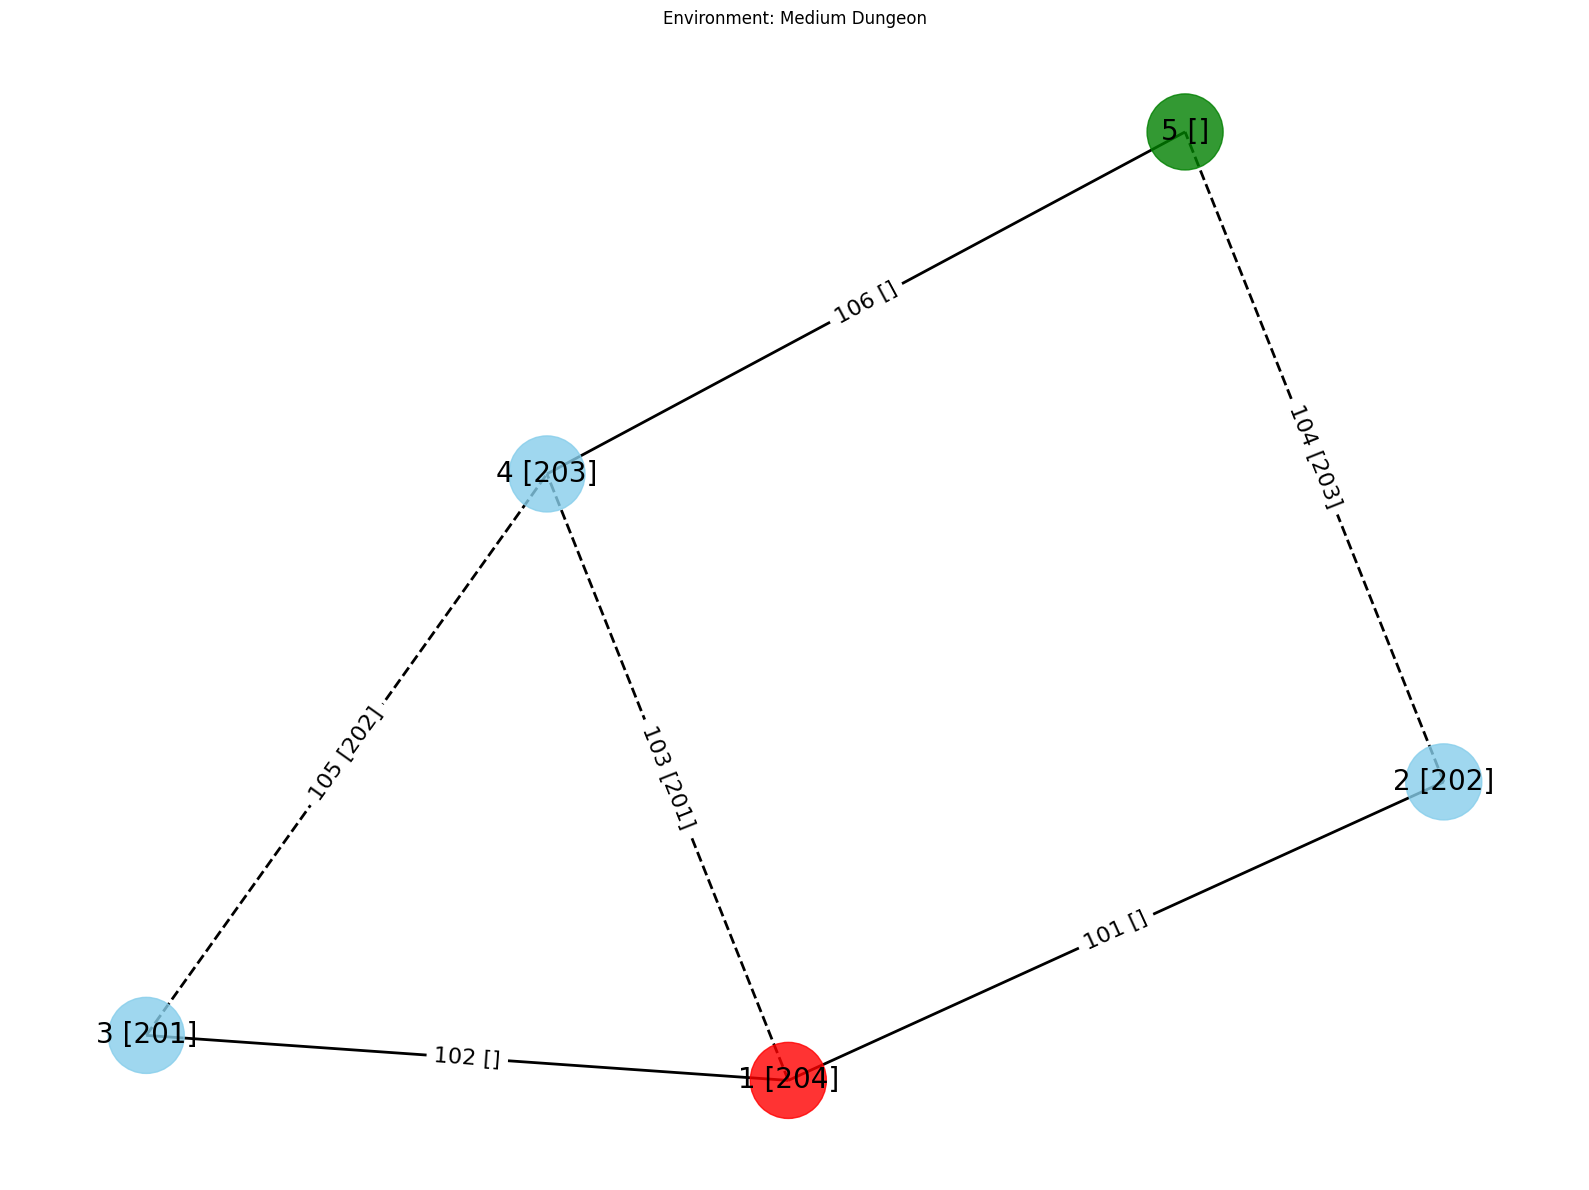

In [12]:
# Create a medium complexity environment
env = EnvironmentFactory.create_medium_environment()

# Visualize it
visualize_environment(env, "environment_visualization.png")

In [13]:
# Create agent
agent = ReACTAgent(
    environment=env,
    client=client,
    model="meta-llama/Meta-Llama-3.1-70B-Instruct",  # Adjust based on available models
    verbose=True,
    max_steps=30
)

# Run agent
result = agent.run()
print(f"\nFinal result: {result['victory']}, steps: {result['steps']}")

Initial observation: {'room_id': 1, 'room_description': 'A grand entrance hall with faded tapestries and a dusty chandelier hanging from the ceiling.', 'doors': [{'id': 101, 'description': 'A door to the east with a carved owl above the frame.', 'locked': False}, {'id': 102, 'description': 'A door to the west with a carved bear above the frame.', 'locked': False}, {'id': 103, 'description': 'A trapdoor in the floor, secured with a rusted padlock.', 'locked': True}]}

--- Step 1 ---
Calling LLM...
Processing tool call: plan, args: {}
Executing planning step...
Planning result: Based on the recent history and the environment description, here's my analysis and plan:

**Current Situation:**

* We are in Room 1, the grand entrance hall.
* We have three doors: two unlocked doors to the east (101) and west (102), and one locked trapdoor (103) in the floor.
* We don't have any keys in our memory.

**Goal:**

* Our ultimate goal is to navigate to the target room containing the artifact.

**Sho

# Part 2. Going further: Multi-Agent Systems

## Breaking down the monolith: a smarter workflow

In previous examples, we’ve seen that a single agent can utilize multiple LLMs. For instance, in the **Dungeon Navigation Agent**, we used:  

- A **"main" LLM** to determine how to interact with the environment and when to plan,  
- A **planner LLM**,  
- A **memory compression LLM**.  

That's only three LLMs, but imagine if our dungeon also included **puzzle-solving, NPC interactions,** and other mechanics. Our `ReACTAgent` class would quickly become bloated and difficult to manage. You may have already noticed this complexity creeping in while developing the **Trader Agent**.  

To address this, instead of cramming everything into one class, we can **decouple different LLM instances into separate agents with shared memory or tools, extracting overall logic from individual agents** and restructuring the workflow as a **graph**, like this:  

<center>  
<img src="https://drive.google.com/uc?export=view&id=19RWIJ9TaZQ6MQrqn-JmHbE90hmeAVDw-" width=600 />  
</center>  

This transforms a single complex agent into a **multi-agent system**. Such systems can become vast and highly interconnected, like Google's [AI co-scientist](https://research.google/blog/accelerating-scientific-breakthroughs-with-an-ai-co-scientist/) framework.  

<center>  
<img src="https://drive.google.com/uc?export=view&id=1Bv2KZzJqIAtVNeYkyhlCptSAiQz_GnXe" width=800 />  
</center>  

## LLM Agents as a team

It's not reckless to imagine that in the future LLM agents will be working for us as "junior co-workers" of sorts. Even now, many sofware developers treat coding AT assistants as junior software engineers, assigning tasks for them, returning with bugs, and trying to teach them - at least for another chat - to avoid some programming anti-patterns. So, why not imagine a whole team consisting of agents?

An example of such framework is [ChatDev](https://github.com/OpenBMB/ChatDev):

<center>  
<img src="https://github.com/OpenBMB/ChatDev/raw/main/misc/company.png" width=600 />  

[Source](https://github.com/OpenBMB/ChatDev)
</center>  

Such systems may a number of specialized agents communicating and interacting in a complicated workflow.

<center>
<img src="https://drive.google.com/uc?export=view&id=1P4SQxjcPoursLLSqjLDDLVeNaltjvQrm" width=600 />

[Source](https://thinkwee.top/multiagent_ebook/communication.html)
</center>  

Of course, setting up such a system isn't easy. You need to make a variety of design choices, such as:

- **Which agent roles are necessary?**  
- **How should the agentic workflow be structured and orchestrated?** For example:  
  - Should interactions follow a predefined graph, or can agents freely delegate tasks to one another?
  - Are any agent calls parallelized?  
- **How do agents communicate with one another?**  
  - Are there special LLM tools for communication, or do they use a shared "blackboard" system?  

One of the most exciting aspects of multi-agent systems is that agents can **enhance each other's "memory of experience," contributing to the system's overall "learning."** This becomes possible if the system stores past experiences - along with some form of external validation - where all agents can access and leverage them. You can think of it as of an advanced, agentic form of **in-context** learning.

For example, a team of coding agents could maintain a database of code they've created for different projects, including both successful implementations and code that received user critique. This way, the system as a whole **gradually "learns" from its history**.


### But There's a Caveat...

Despite its exciting potential, agentic orchestration comes with significant challenges.  

1. One major issue is **LLM hallucinations and overall reliability**. In a complex workflow—especially one where key steps rely on LLM calls—hallucinations can disrupt the entire pipeline unless you have robust error-handling strategies in place.  

2. Another challenge is **designing the right orchestration**, which is notoriously difficult. Striking a balance between hardcoding a specific configuration and creating a flexible, general-purpose framework is no easy task. The former is, of course, an anti-pattern that quickly becomes unmanageable as the framework evolves. The latter, unfortunately, is an elusive goal—many existing frameworks become increasingly complex and unreadable as they attempt to accommodate a wide range of agentic scenarios.  

   To ~scare you~ demonstrate this problem, we created a **toy Multi-Agent System demo** that spans over 1,800 lines of code. Despite our best efforts to keep it simple, it remains quite convoluted—highlighting the inherent difficulties of agentic orchestration. And no, we resisted the temptation to reinvent [LangGraph](https://www.langchain.com/langgraph).  

# A Multi-Agent Worldbuilding system

Imagine you're running a **collaborative worldbuilding studio**, but instead of human writers and artists, you have a team of AI agents — each with their own expertise. You have a **Project Manager AI** overseeing everything and a group of **AI interns**, each focusing on different aspects like geography, history, politics, or culture.  

##  How It Works

1. **The Manager Agent 📋**  
   - Think of this as your head worldbuilder or editor-in-chief.  
   - It decides what needs to be done, hands out assignments, reviews the work, and asks for changes if needed.  

2. **AI Interns 🎨📜**  
   - They may have their own specialization, for example:  
     - The **Geographer** shapes the world's landscapes.  
     - The **Historian** builds historical events and lore.  
     - The **Cultural Expert** defines traditions, customs, and languages.  
     - The **Political Strategist** outlines nations, conflicts, and governance.  
     - You can add more or choose less, if you like!
   - They work independently but communicate and share ideas through a common space.  

## How the system runs a project

1. A **user** provides an initial idea, like `"Create a fantasy world with ancient floating islands and warring sky kingdoms."`  

2. The **Manager Agent** breaks this idea into smaller tasks, taking into account the interns' capabilities. For example:  

  - The **Geographer** defines how the floating islands work.  
  - The **Historian** writes about their origins and past conflicts.  
  - The **Culture Specialist** invents traditions, festivals, and beliefs.  
  - The **Political Strategist** figures out which kingdoms are at war and why.  

3. Each intern agent works on their part and submits content to a shared memory space (**"blackboard"**) and to the manager.  

4. The **Manager Agent** **waits till all the pieces are gathered**, looks at them, and:  

  - If things are inconsistent or someting requires additional work, the manager asks for revisions.  
  - If everything looks good or the number of review iterations is exhausted, it **compiles the world into a final product.**  

5. Steps 3 and 4 are repeated until the **Manager Agent** is happy or until `max_revisions` iterations are run.

6. At the end, the **Manager Agent** assembles everything in one document and gives it back to the user.

Now, if you want to try it, run the next many cells; and in the end, the miracle of worldbuilding awaits you!

**Implementation notes**:

1. The orchestration scheme is a *task queue*. In out case, there are three types of tasks:

  - `finalize_worldbuilding` is sent by the manager; this task *terminates* the process and returns the final worldbuilding.
  - `request_worldbuilding` is broadcast by the manager to the interns asking to create or review their parts of the worldbuilding. It carries manager's suggestions.
  - `request_revisions`is sent by the interns to the manager. It carries intern's ideas.

2. *Sync groups* are used to coordinate tasks that must be synchronized. They ensure that a set number of tasks complete before triggering dependent tasks. In our case it ensures that the manager will wait for all the interns to submit their work before sending them new tasks.

3. *Blackboard* contains whatever was created on the previous steps by all the agents. It serves as a common space to share content.

4. While we tried to make orchestration flexible, we confess that we overindulged in enforcing tool usage, repeating the demands to use tools in the system prompts. Generally, this isn't best practice. It's better to avoid mentioning particular tools outside of their definitions. Otherwise, you get duplicated and poorly manageable code.

5. It could be a good idea to parallelize interns' work by using `async` operations and, in particular, the `AsycnOpenAI` client. We decided against it for the sake of simplicity and also because colab isn't the best environment to exercise parallelity.

**Core classes explained**:

* `Task` (`dataclass`):

  Represents a unit of work for an agent. It contains the target agent ID, instruction (or data), unique task ID, source agent, optional callback, metadata, creation timestamp, result, completion status, potential error, dependencies (other task IDs), and an optional synchronization group.

* `Blackboard`:

  Acts as a shared memory space for collaboration. It allows agents to read and write "facts" (worldbuilding content) and appends timestamped events when updates occur.

* `BaseAgent`:

  The abstract base for all agents. It holds references to the orchestrator, blackboard, and local memory. It defines the interface for handling tasks and provides helper methods (like enqueueing tasks) that are inherited by specialized agents.

* `SyncGroup`:

  Manages synchronization for a group of tasks. It tracks the expected number of tasks, collects completed tasks, manages waiting tasks, handles timeouts, and signals when all tasks in the group have finished, triggering dependent tasks.

* `WorldbuildingOrchestrator`:

  The central controller of the system. It maintains a task queue, tracks pending and completed tasks, handles task dependencies and synchronization (via sync groups), and processes tasks until a final result is produced or the system times out. It also handles logging and task-driven termination.

* `LLMAgent`:

  A specialized agent that leverages an LLM (Large Language Model) for processing tasks. It builds prompts using a system prompt, conversation history, current blackboard state, and manages tool calls (like submit_contribution, request_worldbuilding, etc.). It's used both for the manager and intern agents.

* `WorldbuildingGenerator`:

  The top-level class that ties all components together. It sets up the orchestrator, registers the manager and intern agents (with configurations like specializations and revision limits), and drives the overall worldbuilding process based on a user prompt. It also includes fault tolerance (e.g., timeouts and forced finalization) to ensure the process completes.

In [14]:
import collections
import datetime
import json
import os
import threading
import time
import uuid
from dataclasses import dataclass, field
from enum import Enum, auto
from typing import Any, Callable, Dict, List, Optional, Set, Union

from openai import OpenAI


class LogLevel(Enum):
    """Log levels for orchestrator and agent logging."""
    DEBUG = auto()
    INFO = auto()
    WARNING = auto()
    ERROR = auto()
    CRITICAL = auto()


@dataclass
class Task:
    """Represents a task to be executed by an agent."""
    target_agent_id: str
    instruction: Union[str, Dict[str, Any]]
    task_id: str = field(default_factory=lambda: str(uuid.uuid4()))
    source_agent_id: Optional[str] = None
    callback: Optional[Callable] = None
    metadata: Dict[str, Any] = field(default_factory=dict)
    created_at: datetime.datetime = field(default_factory=datetime.datetime.now)
    result: Any = None
    completed: bool = False
    error: Optional[Exception] = None
    # New field for task dependencies
    depends_on: List[str] = field(default_factory=list)
    # Field for synchronization groups
    sync_group: Optional[str] = None

In [15]:
class Blackboard:
    """Shared memory for worldbuilding collaboration between agents."""

    def __init__(self):
        self._facts = {}
        self._events = []

    def read_fact(self, key: str) -> Any:
        """Read a fact from the blackboard."""
        return self._facts.get(key)

    def write_fact(self, key: str, value: Any) -> None:
        """Write a fact to the blackboard."""
        self._facts[key] = value

        # Track worldbuilding updates
        if key.startswith("worldbuilding_"):
            self.append_event({
                "type": "worldbuilding_update",
                "key": key,
                "value_snippet": str(value)[:100] + ("..." if len(str(value)) > 100 else "")
            })

    def append_event(self, event: Dict[str, Any]) -> None:
        """Append an event to the event log."""
        timestamp = datetime.datetime.now().isoformat()
        event_with_timestamp = {"timestamp": timestamp, **event}
        self._events.append(event_with_timestamp)

    def get_all_facts(self) -> Dict[str, Any]:
        """Get all facts from the blackboard."""
        return self._facts.copy()

    def get_events(self, limit: Optional[int] = None) -> List[Dict[str, Any]]:
        """Get events from the event log, optionally limited to the most recent N events."""
        if limit is None:
            return self._events.copy()
        return self._events[-limit:].copy()

In [16]:
class BaseAgent:
    """Base class for all agents in the worldbuilding system."""

    def __init__(
        self,
        agent_id: str,
        orchestrator: "WorldbuildingOrchestrator",
        blackboard: Optional[Blackboard] = None,
        local_memory: Optional[Dict[str, Any]] = None,
    ):
        self.agent_id = agent_id
        self.orchestrator = orchestrator
        self.blackboard = blackboard or orchestrator.blackboard
        self.local_memory = local_memory or {}

    def handle_task(self, task: Task) -> Any:
        """
        Process a task and return a result.

        Args:
            task: The task to process

        Returns:
            Any result from processing the task
        """
        raise NotImplementedError("Subclasses must implement handle_task")

    def enqueue_task(self,
                    target_agent_id: str,
                    instruction: Union[str, Dict[str, Any]],
                    callback: Optional[Callable] = None,
                    metadata: Optional[Dict[str, Any]] = None,
                    depends_on: Optional[List[str]] = None,
                    sync_group: Optional[str] = None) -> Task:
        """
        Helper method to enqueue a new task.

        Args:
            target_agent_id: ID of the agent that should handle this task
            instruction: Task instruction or data
            callback: Optional callback function for when task completes
            metadata: Optional task metadata
            depends_on: Optional list of task IDs this task depends on
            sync_group: Optional sync group identifier for synchronized tasks

        Returns:
            The created Task object
        """
        task = Task(
            target_agent_id=target_agent_id,
            instruction=instruction,
            source_agent_id=self.agent_id,
            callback=callback,
            metadata=metadata or {},
            depends_on=depends_on or [],
            sync_group=sync_group
        )
        return self.orchestrator.enqueue_task(task)

In [17]:
class SyncGroup:
    """Handles synchronization of tasks in a group."""

    def __init__(self, group_id: str, expected_tasks: int, timeout_seconds: int = 180):
        self.group_id = group_id
        self.expected_tasks = expected_tasks
        self.completed_tasks: Dict[str, Task] = {}
        self.waiting_tasks: List[Task] = []
        self.is_completed = False
        self.timeout_seconds = timeout_seconds
        self.creation_time = time.time()

    def add_task(self, task: Task) -> None:
        """Add a task to the sync group."""
        if task.completed:
            self.completed_tasks[task.task_id] = task
        else:
            self.waiting_tasks.append(task)

    def is_ready(self) -> bool:
        """Check if all expected tasks have completed or timeout occurred."""
        if self.is_completed:
            return False

        # Check if we've timed out
        if time.time() - self.creation_time > self.timeout_seconds:
            return True

        # Check if all expected tasks have completed
        return len(self.completed_tasks) >= self.expected_tasks

    def mark_completed(self) -> None:
        """Mark this sync group as completed."""
        self.is_completed = True

    def get_results(self) -> Dict[str, Any]:
        """Get the results of all completed tasks."""
        return {task_id: task.result for task_id, task in self.completed_tasks.items()}

    def get_waiting_tasks(self) -> List[Task]:
        """Get tasks that are waiting on this sync group."""
        return self.waiting_tasks.copy()

In [18]:
class WorldbuildingOrchestrator:
    """
    Orchestrator for fantasy worldbuilding generation.
    """

    def __init__(
        self,
        blackboard: Optional[Blackboard] = None,
        verbose: bool = False,
        log_level: LogLevel = LogLevel.INFO,
        default_timeout: int = 180  # 3 minutes default timeout
    ):
        # Task queue
        self.task_queue = collections.deque()

        # Task dependencies tracking
        self.pending_tasks: Dict[str, Task] = {}
        self.completed_tasks: Dict[str, Task] = {}

        # Sync groups for synchronized task execution
        self.sync_groups: Dict[str, SyncGroup] = {}

        # Shared resources
        self.blackboard = blackboard or Blackboard()

        # Agent registry
        self.agents: Dict[str, BaseAgent] = {}

        # Logging settings
        self.verbose = verbose
        self.log_level = log_level

        # Result tracking
        self.final_result = None

        # Default timeout
        self.default_timeout = default_timeout

        # Revision tracking
        self.revision_count = 0
        self.max_revisions = 3

    def register_agent(self, agent: BaseAgent) -> None:
        """
        Register an agent with the orchestrator.

        Args:
            agent: The agent to register
        """
        self.agents[agent.agent_id] = agent
        self._log(LogLevel.INFO, f"Registered agent {agent.agent_id}")

    def enqueue_task(self, task: Task) -> Task:
        """
        Add a task to the queue for processing.

        Args:
            task: The task to enqueue

        Returns:
            The enqueued task (not necessarily completed)
        """
        if task.target_agent_id not in self.agents:
            self._log(
                LogLevel.WARNING,
                f"Task for unknown agent {task.target_agent_id}. Known agents: {list(self.agents.keys())}"
            )
            task.error = ValueError(f"Unknown agent: {task.target_agent_id}")
            return task

        # Add to pending tasks
        self.pending_tasks[task.task_id] = task

        # Check if task is part of a sync group
        if task.sync_group:
            if task.sync_group not in self.sync_groups:
                # First task in this group, determine expected task count
                expected_tasks = len([a for a in self.agents if a != "manager"])
                self.sync_groups[task.sync_group] = SyncGroup(
                    task.sync_group,
                    expected_tasks,
                    self.default_timeout
                )
            self.sync_groups[task.sync_group].add_task(task)

        # Check if all dependencies are met
        if all(dep_id in self.completed_tasks for dep_id in task.depends_on):
            self.task_queue.append(task)
            self._log(
                LogLevel.DEBUG,
                f"Queued task {task.task_id} for agent {task.target_agent_id}"
            )
        else:
            self._log(
                LogLevel.DEBUG,
                f"Task {task.task_id} waiting for dependencies: {task.depends_on}"
            )

        # Process any available tasks
        self.process_available_tasks()

        return task

    def process_available_tasks(self) -> None:
        """Process all available tasks in the queue."""
        # Process normal queue
        while self.task_queue:
            self.process_next_task()

        # Check if any sync groups are ready
        for group_id, sync_group in list(self.sync_groups.items()):
            if sync_group.is_ready():
                self._log(
                    LogLevel.INFO,
                    f"Sync group {group_id} is ready with {len(sync_group.completed_tasks)}/{sync_group.expected_tasks} tasks"
                )

                # If timed out, log a warning
                if len(sync_group.completed_tasks) < sync_group.expected_tasks:
                    self._log(
                        LogLevel.WARNING,
                        f"Sync group {group_id} timed out after {self.default_timeout}s with {len(sync_group.completed_tasks)}/{sync_group.expected_tasks} tasks"
                    )

                # For each waiting task, add its results to metadata and queue it
                for waiting_task in sync_group.get_waiting_tasks():
                    waiting_task.metadata["sync_results"] = sync_group.get_results()
                    self.task_queue.append(waiting_task)

                # Mark as completed and remove
                sync_group.mark_completed()

                # Process the newly queued tasks
                self.process_available_tasks()
                return

    def process_next_task(self) -> Optional[Task]:
        """
        Process the next task in the queue.

        Returns:
            The completed task or None if queue is empty
        """
        if not self.task_queue:
            return None

        task = self.task_queue.popleft()
        agent_id = task.target_agent_id

        if agent_id not in self.agents:
            self._log(LogLevel.ERROR, f"No agent found for ID: {agent_id}")
            task.error = ValueError(f"No agent found for ID: {agent_id}")
            return task

        agent = self.agents[agent_id]

        self._log(
            LogLevel.INFO,
            f"Agent {agent_id} handling task: {task.task_id} from {task.source_agent_id or 'user'}"
        )

        try:
            # Execute the task
            result = agent.handle_task(task)

            # Update task with result
            task.result = result
            task.completed = True

            # Move from pending to completed
            if task.task_id in self.pending_tasks:
                del self.pending_tasks[task.task_id]
            self.completed_tasks[task.task_id] = task

            # Update sync group if applicable
            if task.sync_group and task.sync_group in self.sync_groups:
                self.sync_groups[task.sync_group].add_task(task)

            # Call callback if provided
            if task.callback:
                task.callback(result)

            self._log(
                LogLevel.DEBUG,
                f"Completed task {task.task_id} for agent {agent_id}"
            )

            # Check if this is a termination task with a result
            if isinstance(result, dict) and result.get("terminate", False):
                self._log(
                    LogLevel.INFO,
                    f"Received terminate signal from agent {agent_id}."
                )
                self.final_result = result.get("result")

            # Check if there are any tasks that were waiting on this one
            self.process_dependent_tasks(task.task_id)

        except Exception as e:
            task.error = e
            self._log(
                LogLevel.ERROR,
                f"Error processing task {task.task_id} for agent {agent_id}: {str(e)}"
            )
            import traceback
            self._log(LogLevel.ERROR, traceback.format_exc())

            # Still mark as completed to avoid blocking dependencies
            task.completed = True
            if task.task_id in self.pending_tasks:
                del self.pending_tasks[task.task_id]
            self.completed_tasks[task.task_id] = task

            # Update sync group if applicable
            if task.sync_group and task.sync_group in self.sync_groups:
                self.sync_groups[task.sync_group].add_task(task)

            # Check for dependent tasks
            self.process_dependent_tasks(task.task_id)

        return task

    def process_dependent_tasks(self, completed_task_id: str) -> None:
        """
        Check if any pending tasks can now be queued due to a completed dependency.

        Args:
            completed_task_id: The ID of the task that just completed
        """
        newly_ready = []

        for task_id, task in list(self.pending_tasks.items()):
            if completed_task_id in task.depends_on:
                # Check if all dependencies are now satisfied
                if all(dep_id in self.completed_tasks for dep_id in task.depends_on):
                    newly_ready.append(task)

        # Queue any newly ready tasks
        for task in newly_ready:
            self.task_queue.append(task)
            self._log(
                LogLevel.DEBUG,
                f"Task {task.task_id} now ready as dependencies are satisfied"
            )

        # Process them if any
        if newly_ready:
            self.process_available_tasks()

    def run(self, initial_task: Task) -> Any:
        """
        Run the orchestrator with an initial task.

        Args:
            initial_task: The first task to process

        Returns:
            The final result
        """
        self.final_result = None
        self.revision_count = 0

        # Process the initial task, which may enqueue more tasks
        self.enqueue_task(initial_task)

        # Process any remaining tasks in the queue
        while (self.pending_tasks or self.task_queue) and self.final_result is None:
            self.process_available_tasks()

            # Short sleep to prevent CPU spinning
            time.sleep(0.1)

        # Log all facts in the blackboard for debugging
        self._log(LogLevel.INFO, f"Final blackboard contents:")
        for key, value in self.blackboard.get_all_facts().items():
            self._log(LogLevel.INFO, f"  {key}: {str(value)[:100]}...")

        # If we don't have a result, check the blackboard
        if not self.final_result:
            self.final_result = self.blackboard.read_fact("final_worldbuilding")

        # If still no result, set a fallback message
        if not self.final_result:
            self._log(LogLevel.WARNING, f"No final worldbuilding was returned!")
            self.final_result = "No worldbuilding was produced. Please check the system logs for details."

        return self.final_result

    def _log(self, level: LogLevel, message: str) -> None:
        """
        Log a message with the specified level.

        Args:
            level: The log level
            message: The message to log
        """
        if level.value >= self.log_level.value:
            timestamp = datetime.datetime.now().isoformat()
            log_message = f"[{timestamp}] [{level.name}] {message}"

            if self.verbose or level.value >= LogLevel.WARNING.value:
                print(log_message)

In [19]:
class LLMAgent(BaseAgent):
    """Agent that uses an LLM for task handling with automatic blackboard access and tools."""

    def __init__(
        self,
        agent_id: str,
        orchestrator: WorldbuildingOrchestrator,
        client: OpenAI,
        system_prompt: str,
        tools: Optional[List[Dict[str, Any]]] = None,
        model: str = "gpt-3.5-turbo-0125",
        temperature: float = 0.7,
        tool_choice: Union[str, Dict[str, Any]] = "auto",
        blackboard: Optional[Blackboard] = None,
        local_memory: Optional[Dict[str, Any]] = None,
    ):
        super().__init__(
            agent_id=agent_id,
            orchestrator=orchestrator,
            blackboard=blackboard,
            local_memory=local_memory or {},
        )
        self.client = client
        self.system_prompt = system_prompt
        self.tools = tools or []
        self.model = model
        self.temperature = temperature
        self.tool_choice = tool_choice
        self.conversation_history = []

    def handle_task(self, task: Task) -> Any:
        """Process a task using the LLM with automatic blackboard access."""
        instruction = task.instruction

        # Prepare messages for the LLM
        messages = [{"role": "system", "content": self.system_prompt}]

        # Add conversation history if available
        if self.conversation_history:
            messages.extend(self.conversation_history[-10:])  # Limit to last 10 messages

        # Add current state information to the instruction
        enhanced_instruction = f"""
    {instruction}

    CURRENT STATE:
    """

        # Add sync results if available (for manager reviewing intern contributions)
        if "sync_results" in task.metadata:
            enhanced_instruction += "\nINTERN CONTRIBUTIONS:\n"
            for task_id, result in task.metadata["sync_results"].items():
                source_agent = "Unknown"
                if isinstance(result, dict) and "source_agent" in result:
                    source_agent = result["source_agent"]
                    result_content = result.get("content", str(result))
                    result_preview = result_content[:500] + ("..." if len(result_content) > 500 else "")
                    enhanced_instruction += f"\nFrom {source_agent}:\n{result_preview}"
                elif isinstance(result, str):
                    # Try to extract just the first part to avoid huge logs
                    result_preview = result[:500] + ("..." if len(result) > 500 else "")
                    enhanced_instruction += f"\nFrom {source_agent}:\n{result_preview}\n"
                else:
                    enhanced_instruction += f"\n {source_agent}: {str(result)[:200]}...\n"

            # Add revision count as context
            enhanced_instruction += f"\nThis is revision round {self.orchestrator.revision_count + 1}.\n"

        # Add blackboard world content - this is a programmed read operation
        world_facts = {k: v for k, v in self.blackboard.get_all_facts().items()
                      if k.startswith("worldbuilding_")}

        if world_facts:
            enhanced_instruction += "\nCURRENT WORLDBUILDING:\n"
            for key, value in world_facts.items():
                # Clean up the key name
                display_key = key.replace("worldbuilding_", "").replace("_", " ").title()
                enhanced_instruction += f"\n{display_key}:\n{value}\n"

        # For interns, add specific instruction to use tools
        if self.agent_id != "manager":
            enhanced_instruction += """
    YOU MUST USE THE submit_contribution TOOL to provide your worldbuilding content.
    """

        # Add the enhanced instruction
        messages.append({"role": "user", "content": enhanced_instruction})

        # Debug: Log the input messages - log the full message to catch issues
        self.orchestrator._log(
            LogLevel.DEBUG,
            f"Agent {self.agent_id} sending messages to LLM. System prompt: {self.system_prompt[:100]}..., Instruction: {enhanced_instruction[:300]}..."
        )

        try:
            # Use the agent's tool_choice parameter if tools are available
            current_tool_choice = self.tool_choice if self.tools else None

            # Make the LLM call
            completion = self.client.chat.completions.create(
                model=self.model,
                messages=messages,
                temperature=self.temperature,
                tools=self.tools if self.tools else None,
                tool_choice=current_tool_choice
            )

            # Extract the response
            assistant_message = completion.choices[0].message
            content = assistant_message.content or ""

            # Log the full response
            self.orchestrator._log(
                LogLevel.DEBUG,
                f"Agent {self.agent_id} received response: {content[:300]}..."
            )

            # Update conversation history
            self.conversation_history.append({"role": "user", "content": enhanced_instruction})

            # Check for tool calls
            tool_calls = getattr(assistant_message, "tool_calls", None)

            # Log the tool calls if present
            if tool_calls:
                self.orchestrator._log(
                    LogLevel.DEBUG,
                    f"Agent {self.agent_id} received tool calls: {[tc.function.name for tc in tool_calls]}"
                )
                for tc in tool_calls:
                    self.orchestrator._log(
                        LogLevel.DEBUG,
                        f"Tool call details - Name: {tc.function.name}, Args: {tc.function.arguments}"
                    )
            else:
                return {"content": "Failed", "source_agent": self.agent_id}

            if tool_calls:
                # Handle tool calls
                tool_results = []
                for tool_call in tool_calls:
                    function_name = tool_call.function.name
                    try:
                        function_args = json.loads(tool_call.function.arguments)
                    except json.JSONDecodeError:
                        self.orchestrator._log(
                            LogLevel.ERROR,
                            f"Failed to parse arguments for tool {function_name}: {tool_call.function.arguments}"
                        )
                        continue

                    # Execute the tool function dynamically
                    # Execute the tool function
                    try:
                        method = getattr(self, function_name)
                        result = method(**function_args)
                        tool_results.append({
                            "tool_call_id": tool_call.id,
                            "role": "tool",
                            "name": function_name,
                            "content": json.dumps(result)
                        })
                    except (AttributeError, TypeError) as e:
                        self.orchestrator._log(
                            LogLevel.ERROR,
                            f"Error calling {function_name} by {self.agent_id}: {str(e)}"
                        )

                # Add the assistant message and tool results to history
                self.conversation_history.append({
                    "role": "assistant",
                    "content": content,
                    "tool_calls": [
                        {
                            "id": tc.id,
                            "type": "function",
                            "function": {
                                "name": tc.function.name,
                                "arguments": tc.function.arguments
                            }
                        } for tc in tool_calls
                    ]
                })

                for tool_result in tool_results:
                    self.conversation_history.append(tool_result)

                return {"content": "success", "source_agent": self.agent_id}
            else:
                # No tool calls, just return the content
                self.conversation_history.append({"role": "assistant", "content": content})
                return {"content": content, "source_agent": self.agent_id}

        except Exception as e:
            self.orchestrator._log(
                LogLevel.ERROR,
                f"Error in LLM call for agent {self.agent_id}: {str(e)}"
            )
            import traceback
            self.orchestrator._log(LogLevel.ERROR, traceback.format_exc())
            return f"Error: {str(e)}"

    # Debug printing helper
    def _debug_print_object(self, obj, label="Object", max_depth=2):
        """Print an object's structure for debugging purposes"""
        import json

        def process_obj(o, current_depth=0):
            if current_depth >= max_depth:
                return str(o)[:100] + ("..." if len(str(o)) > 100 else "")

            if isinstance(o, dict):
                return {k: process_obj(v, current_depth+1) for k, v in o.items()}
            elif isinstance(o, list):
                return [process_obj(i, current_depth+1) for i in o[:5]] + (["..."] if len(o) > 5 else [])
            else:
                return str(o)[:100] + ("..." if len(str(o)) > 100 else "")

        try:
            processed = process_obj(obj)
            result = json.dumps(processed, indent=2)
            self.orchestrator._log(LogLevel.DEBUG, f"{label}: {result}")
            return result
        except:
            result = str(obj)[:200]
            self.orchestrator._log(LogLevel.DEBUG, f"{label} (couldn't serialize): {result}")
            return result

    # Tool implementation methods directly in the LLMAgent class

    def request_worldbuilding(self, specializations):
        """
        Handle worldbuilding requests from the manager.

        Args:
            specializations: List of dictionaries with 'intern_id' and 'focus_area' keys

        Returns:
            Status and task information
        """
        # Debug print the input
        self._debug_print_object(specializations, "specializations argument")

        # Create a unique sync group for this round of requests
        sync_group_id = f"worldbuilding_round_{time.time()}"

        # Create tasks for all requested interns
        task_ids = []

        # Handle various input formats - ensure we have a list of dicts
        if not isinstance(specializations, list):
            self.orchestrator._log(
                LogLevel.WARNING,
                f"Expected list for specializations, got {type(specializations)}: {specializations}"
            )
            if isinstance(specializations, dict):
                specializations = [specializations]
            else:
                # Try to parse it as a string representation of a JSON list/dict
                try:
                    import json
                    parsed = json.loads(specializations)
                    if isinstance(parsed, dict):
                        specializations = [parsed]
                    elif isinstance(parsed, list):
                        specializations = parsed
                    else:
                        raise ValueError(f"Couldn't convert {specializations} to list of dicts")
                except:
                    # Last resort - create a list with one item per intern
                    intern_ids = list(self.orchestrator.agents.keys())
                    intern_ids.remove("manager")  # Remove manager from list

                    if isinstance(specializations, str):
                        # Use the string as the focus area for all interns
                        specializations = [
                            {"intern_id": intern_id, "focus_area": specializations}
                            for intern_id in intern_ids
                        ]
                    else:
                        # Can't parse - use default focus areas
                        self.orchestrator._log(
                            LogLevel.ERROR,
                            f"Could not parse specializations: {specializations}"
                        )
                        specializations = [
                            {"intern_id": "geography_intern", "focus_area": "geography"},
                            {"intern_id": "history_intern", "focus_area": "history"},
                            {"intern_id": "politics_intern", "focus_area": "politics"},
                            {"intern_id": "culture_intern", "focus_area": "culture"}
                        ]

        for spec in specializations:
            # Handle the case where spec is not a dict
            if not isinstance(spec, dict):
                self.orchestrator._log(
                    LogLevel.WARNING,
                    f"Expected dict for specialization, got {type(spec)}: {spec}"
                )
                continue

            intern_id = spec.get("intern_id")
            focus_area = spec.get("focus_area")

            if not intern_id or not focus_area:
                continue

            # Validate the intern exists
            if intern_id not in self.orchestrator.agents:
                self.orchestrator._log(
                    LogLevel.WARNING,
                    f"Requested unknown intern {intern_id}, skipping"
                )
                continue

            prompt = f"""
You are creating the {focus_area} for our fantasy world.

Please provide detailed worldbuilding content focused on {focus_area}.
Be creative, coherent, and consider any existing worldbuilding already on the blackboard.

Submit your contribution using the submit_contribution tool.
"""

            task = self.enqueue_task(
                target_agent_id=intern_id,
                instruction=prompt,
                sync_group=sync_group_id
            )
            task_ids.append(task.task_id)

            self.orchestrator._log(
                LogLevel.INFO,
                f"Created task for intern {intern_id} to develop {focus_area}"
            )

        # Create a manager task that will execute after all interns respond
        review_task = self.enqueue_task(
            target_agent_id="manager",
            instruction=manager_review_prompt.format(
                revision_round=self.orchestrator.revision_count,
                max_revisions=self.orchestrator.max_revisions
            ),
            sync_group=sync_group_id
        )

        return {
            "status": "success",
            "interns_assigned": len(task_ids),
            "review_task_id": review_task.task_id,
            "sync_group": sync_group_id
        }

    def request_revisions(self, feedback):
        """
        Handle revision requests from the manager.

        Args:
            feedback: List of dictionaries with 'intern_id' and 'revision_request' keys
                or string containing JSON

        Returns:
            Status and task information
        """
        # Debug print the input
        self._debug_print_object(feedback, "feedback argument")

        # Increment the revision count
        self.orchestrator.revision_count += 1

        # Add debug printing of revision count
        self.orchestrator._log(
            LogLevel.INFO,
            f"=== STARTING REVISION ROUND {self.orchestrator.revision_count}/{self.orchestrator.max_revisions} ==="
        )

        # Check if we've exceeded max revisions
        if self.orchestrator.revision_count >= self.orchestrator.max_revisions:
            self.orchestrator._log(
                LogLevel.WARNING,
                f"Maximum revision rounds ({self.orchestrator.max_revisions}) reached"
            )
            # Instead of error, just finalize the worldbuilding at this point
            self.orchestrator._log(
                LogLevel.INFO,
                f"Max revisions reached, auto-finalizing worldbuilding"
            )
            return self.finalize_worldbuilding()

        # Create a unique sync group for this round of revisions
        sync_group_id = f"revision_round_{self.orchestrator.revision_count}_{time.time()}"

        # Ensure feedback is properly formatted
        processed_feedback = None

        # If feedback is a string, try to parse it as JSON
        if isinstance(feedback, str):
            try:
                processed_feedback = json.loads(feedback)
                self.orchestrator._log(
                    LogLevel.INFO,
                    f"Successfully parsed feedback string as JSON"
                )
            except json.JSONDecodeError:
                self.orchestrator._log(
                    LogLevel.ERROR,
                    f"Failed to parse feedback string as JSON: {feedback}"
                )
                # Auto-finalize on error
                return self.finalize_worldbuilding()
        else:
            processed_feedback = feedback

        # Handle if processed_feedback is still not a list
        if not isinstance(processed_feedback, list):
            if isinstance(processed_feedback, dict):
                # Single feedback item
                processed_feedback = [processed_feedback]
            else:
                self.orchestrator._log(
                    LogLevel.ERROR,
                    f"Expected list for feedback, got {type(processed_feedback)}: {processed_feedback}"
                )
                # Auto-finalize on error
                return self.finalize_worldbuilding()

        # Create tasks for each intern that needs to make revisions
        task_ids = []

        for item in processed_feedback:
            if not isinstance(item, dict):
                self.orchestrator._log(
                    LogLevel.WARNING,
                    f"Expected dict for feedback item, got {type(item)}: {item}"
                )
                continue

            intern_id = item.get("intern_id")
            revision_request = item.get("revision_request")

            if not intern_id or not revision_request:
                continue

            # Validate the intern exists
            if intern_id not in self.orchestrator.agents:
                self.orchestrator._log(
                    LogLevel.WARNING,
                    f"Requested revision from unknown intern {intern_id}, skipping"
                )
                continue

            prompt = f"""
    Please revise your worldbuilding contribution based on the following feedback:

    {revision_request}

    Remember to consider the overall worldbuilding and maintain consistency with other parts.
    Submit your revised contribution using the submit_contribution tool.
    """

            task = self.enqueue_task(
                target_agent_id=intern_id,
                instruction=prompt,
                sync_group=sync_group_id
            )
            task_ids.append(task.task_id)

            self.orchestrator._log(
                LogLevel.INFO,
                f"Created revision task for intern {intern_id} (round {self.orchestrator.revision_count})"
            )

        # If no tasks were created, finalize the worldbuilding
        if not task_ids:
            self.orchestrator._log(
                LogLevel.WARNING,
                f"No valid revision tasks created, auto-finalizing worldbuilding"
            )
            return self.finalize_worldbuilding()

        # Create a manager task that will execute after all revisions are submitted
        review_task = self.enqueue_task(
            target_agent_id="manager",
            instruction=manager_review_prompt.format(
                revision_round=self.orchestrator.revision_count,
                max_revisions=self.orchestrator.max_revisions
            ),
            sync_group=sync_group_id
        )

        return {
            "status": "success",
            "revision_round": self.orchestrator.revision_count,
            "interns_assigned": len(task_ids),
            "review_task_id": review_task.task_id
        }

    def finalize_worldbuilding(self, final_worldbuilding=None):
        """
        Handle the finalize_worldbuilding tool call.

        Args:
            final_worldbuilding: Optional final worldbuilding text. If not provided,
                         compiles content from the blackboard.

        Returns:
            Status with terminate signal
        """
        # If no final worldbuilding is provided, have the manager create it
        if final_worldbuilding is None or final_worldbuilding == "":
            self.orchestrator._log(
                LogLevel.INFO,
                f"No final worldbuilding provided, requesting manager to create finalized version"
            )

            # Get all worldbuilding content from blackboard
            world_facts = {k: v for k, v in self.blackboard.get_all_facts().items()
                      if k.startswith("worldbuilding_")}

            if not world_facts:
                final_worldbuilding = "No worldbuilding content was created."
                self.orchestrator._log(
                    LogLevel.WARNING,
                    f"No worldbuilding content found in blackboard"
                )
            else:
                # Format the content as a prompt for the manager
                sections_text = ""
                for key in sorted(world_facts.keys()):
                    value = world_facts[key]
                    display_key = key.replace("worldbuilding_", "").replace("_", " ").title()
                    sections_text += f"\n## {display_key}\n{value}\n"

                # Create a prompt for the manager to finalize the worldbuilding
                finalize_prompt = f"""
You must now create the FINAL comprehensiveworldbuilding document by integrating all sections below.
Make sure the document is cohesive, well-formatted, and resolves any inconsistencies.
Add appropriate section headings and organization. This is the final product that will
be delivered to the user.

CURRENT WORLDBUILDING SECTIONS:
{sections_text}

Create a complete, integrated worldbuilding document from these sections.
"""
                # Only call the LLM if this is the manager agent
                if self.agent_id == "manager":
                    try:
                        # Make an LLM call to format the final document
                        messages = [{"role": "system", "content": self.system_prompt},
                                   {"role": "user", "content": finalize_prompt}]

                        completion = self.client.chat.completions.create(
                            model=self.model,
                            messages=messages,
                            temperature=0.5  # Lower temperature for more consistent formatting
                        )

                        # Extract the response
                        final_worldbuilding = completion.choices[0].message.content or ""

                        self.orchestrator._log(
                            LogLevel.INFO,
                            f"Manager created finalized worldbuilding ({len(final_worldbuilding)} chars)"
                        )
                    except Exception as e:
                        self.orchestrator._log(
                            LogLevel.ERROR,
                            f"Error creating finalized worldbuilding: {str(e)}"
                        )
                        # Fall back to simple compilation
                        sections = []
                        for key in sorted(world_facts.keys()):
                            value = world_facts[key]
                            display_key = key.replace("worldbuilding_", "").replace("_", " ").title()
                            sections.append(f"# {display_key}\n{value}\n")

                        final_worldbuilding = "\n".join(sections)
                else:
                    # If not the manager, just compile sections
                    sections = []
                    for key in sorted(world_facts.keys()):
                        value = world_facts[key]
                        display_key = key.replace("worldbuilding_", "").replace("_", " ").title()
                        sections.append(f"# {display_key}\n{value}\n")

                    final_worldbuilding = "\n".join(sections)

        # Store the final result - programmed write operation
        self.orchestrator._log(
            LogLevel.INFO,
            f"Finalizing worldbuilding ({len(final_worldbuilding)} chars)"
        )
        self.blackboard.write_fact("final_worldbuilding", final_worldbuilding)

        return {
            "terminate": True,
            "result": final_worldbuilding
        }

    def submit_contribution(self, content, category=None):
        """
        Handle the submit_contribution tool call for interns.

        Args:
            content: The worldbuilding content contributed by the intern
            category: Optional category for the contribution (e.g., "geography", "history")
                    If not provided, uses the intern's ID

        Returns:
            Status information
        """
        # Determine the category key
        if not category:
            # Try to extract from agent ID
            if self.agent_id.endswith("_intern"):
                category = self.agent_id.replace("_intern", "")
            else:
                category = self.agent_id

        # Clean up the category for the blackboard key
        blackboard_key = f"worldbuilding_{category.lower().replace(' ', '_')}"

        # Store the content - programmed write operation
        self.blackboard.write_fact(blackboard_key, content)

        # Log the action
        self.orchestrator._log(
            LogLevel.INFO,
            f"Intern {self.agent_id} submitted contribution for {category}: {content[:100]}..."
        )

        return {
            "status": "success",
            "category": category,
            "blackboard_key": blackboard_key,
            "content_length": len(content),
            "source_agent": self.agent_id
        }



In [20]:
# Updated Manager System Prompt
manager_system_prompt = """
You are the Manager of a fantasy worldbuilding team. Your role is to:
1. Delegate specialized worldbuilding tasks to intern agents
2. Review their contributions for consistency and quality
3. Request revisions when necessary
4. Finalize the worldbuilding when complete and coherent

AVAILABLE INTERNS AND THEIR SPECIALIZATIONS:
{intern_list}

RULES:
- NEVER create worldbuilding content yourself
- ALWAYS use the request_worldbuilding tool to delegate to interns based on their specializations
- Request revisions using the request_revisions tool when needed
- When you decide the worldbuilding is complete, you MUST use the finalize_worldbuilding tool
- DO NOT just say you will finalize - you must actually call the finalize_worldbuilding tool
- Ensure consistency across all worldbuilding elements
- Each revision should focus on enhancing consistency between different aspects

IMPORTANT:
1. Instruct interns to either CREATE NEW content if the blackboard is empty, or REFINE
   existing content to make it more consistent with what others have contributed
2. Evaluate how well elements from different specialists connect and fit together
3. Request targeted revisions that improve consistency across the world
4. ALWAYS use the finalize_worldbuilding tool after the maximum revision rounds
5. NEVER just state that the worldbuilding is complete - you must USE THE TOOL to finalize it

USE THESE TOOLS:
- request_worldbuilding: Assign specialized areas to intern agents
- request_revisions: Ask for specific changes to improve contributions
- finalize_worldbuilding: Complete the worldbuilding project and return the result
"""

# Updated Intern System Prompt
intern_system_prompt = """
You are a {specialization} Worldbuilding Intern. Your job is to:
1. Create detailed, coherent fantasy worldbuilding content focused on {specialization}
2. Submit your contribution using the submit_contribution tool
3. Make revisions when requested by the Manager
4. Ensure your content is consistent with the overall world

IMPORTANT:
- If you are the first to contribute or if there's no existing content, be CREATIVE and establish foundations
- If there is existing content from other interns, FOCUS ON CONSISTENCY and connect your elements to theirs
- Be detailed, immersive, and imaginative
- Always check the current worldbuilding state before contributing
- When revising, focus on making your content work well with other specialists' contributions
- Always use the submit_contribution tool to provide your worldbuilding content

WORLDBUILDING GUIDANCE:
- Create content that fits cohesively with the existing world
- Include unique elements that enrich the world without contradicting other aspects
- When revising, prioritize connections between different specialists' work
- Consider how your area ({specialization}) interacts with geography, history, politics, and culture

{prompt_customization}
"""

# Manager's initial prompt
initial_manager_prompt = """
{user_request}

As the Manager, your job is to:
1. Delegate specific aspects of worldbuilding to specialized interns based on their expertise
2. Review their work for consistency and quality
3. Request revisions to enhance coherence between different aspects
4. Use finalize_worldbuilding tool when done

Start by using the request_worldbuilding tool to delegate tasks to the appropriate interns, instructing them to:
- Create foundational elements for their areas of expertise that support the world concept
- Consider how their contributions will interact with other aspects of the world
"""

# Manager review prompt
manager_review_prompt = """
Review the contributions from the interns and decide if revisions are needed or if the worldbuilding is complete.

IMPORTANT CONSIDERATIONS:
1. How well do the different aspects (geography, history, politics, culture) connect with each other?
2. Are there inconsistencies or contradictions between different sections?
3. Are there opportunities to strengthen connections between different elements?
4. Is the worldbuilding comprehensive and coherent enough to finalize?

If the worldbuilding needs revisions, use the request_revisions tool with specific feedback.
If the worldbuilding is complete and coherent, use the finalize_worldbuilding tool.

Current revision round: {revision_round}/{max_revisions}
"""

In [21]:
import traceback

class WorldbuildingGenerator:
    """Main class for fantasy worldbuilding using a multi-agent system."""

    def __init__(
        self,
        client: Optional[OpenAI] = None,
        default_model: str = "gpt-3.5-turbo-0125",
        default_temperature: float = 0.7,
        verbose: bool = False,
        timeout_seconds: int = 300,  # 5-minute timeout
        intern_configs: Optional[List[Dict[str, Any]]] = None,
        log_level: LogLevel = LogLevel.INFO,
        max_revisions: int = 3
    ):
        """
        Initialize the worldbuilding generator.

        Args:
            client: OpenAI client instance (if None, creates one using NEBIUS_API_KEY)
            default_model: Default model to use for LLM calls
            default_temperature: Default temperature for LLM generation
            verbose: Whether to show detailed logging
            timeout_seconds: Maximum time to allow for worldbuilding creation
            intern_configs: Optional list of intern configurations, each with:
                - 'id': Intern ID (required)
                - 'specialization': Area of focus (required)
                - 'model': Model name (optional)
                - 'temperature': Temperature value (optional)
                - 'prompt_customization': Custom prompt additions (optional)
            log_level: Logging level (DEBUG, INFO, etc.)
            max_revisions: Maximum number of revision rounds
        """
        # Initialize OpenAI client if not provided
        if client is None:
            api_key = os.environ.get("NEBIUS_API_KEY")
            if not api_key:
                raise ValueError("No API key found. Set NEBIUS_API_KEY environment variable or pass a client instance.")

            self.client = OpenAI(
                base_url="https://api.studio.nebius.ai/v1/",
                api_key=api_key
            )
        else:
            self.client = client

        self.default_model = default_model
        self.default_temperature = default_temperature
        self.timeout_seconds = timeout_seconds

        # Create orchestrator with specified log level
        self.orchestrator = WorldbuildingOrchestrator(
            verbose=verbose,
            log_level=log_level,
            default_timeout=timeout_seconds // 2  # Set sync group timeout to half of total timeout
        )
        self.orchestrator.max_revisions = max_revisions

        # Use default intern configurations if none provided
        if not intern_configs:
            # Default: create standard worldbuilding interns
            intern_configs = [
                {'id': 'geography_intern', 'specialization': 'Geography'},
                {'id': 'history_intern', 'specialization': 'History'},
                {'id': 'politics_intern', 'specialization': 'Politics'},
                {'id': 'culture_intern', 'specialization': 'Culture'}
            ]

        # Store intern specializations in the blackboard for the manager to access
        intern_registry = {}
        for config in intern_configs:
            intern_id = config.get('id')
            specialization = config.get('specialization')
            if intern_id and specialization:
                intern_registry[intern_id] = specialization

        self.orchestrator.blackboard.write_fact("intern_specializations", intern_registry)

        # Create and register manager agent with safety mechanisms
        self.manager = self.create_manager_with_safety_net(intern_registry)
        self.orchestrator.register_agent(self.manager)

        # Create and register intern agents with updated prompts
        self.interns = []
        for config in intern_configs:
            intern_id = config.get('id')
            specialization = config.get('specialization')

            if not intern_id or not specialization:
                raise ValueError("Each intern config must include 'id' and 'specialization'")

            # Format the intern system prompt with their specialization
            prompt_customization = config.get('prompt_customization', '')
            system_prompt = intern_system_prompt.format(
                specialization=specialization,
                prompt_customization=prompt_customization
            )

            tools = [
                {
                    "type": "function",
                    "function": {
                        "name": "submit_contribution",
                        "description": "Submit your worldbuilding contribution",
                        "parameters": {
                            "type": "object",
                            "properties": {
                                "content": {
                                    "type": "string",
                                    "description": "The worldbuilding content you've created"
                                },
                                "category": {
                                    "type": "string",
                                    "description": "Optional category for your contribution (defaults to your specialization)"
                                }
                            },
                            "required": ["content"]
                        }
                    }
                }
            ]

            intern = LLMAgent(
                agent_id=intern_id,
                orchestrator=self.orchestrator,
                client=self.client,
                system_prompt=system_prompt,
                tools=tools,
                model=config.get('model') or self.default_model,
                temperature=config.get('temperature') or (self.default_temperature + 0.1),  # Slightly higher for creativity
                tool_choice="auto"
            )

            self.interns.append(intern)
            self.orchestrator.register_agent(intern)

    def create_manager_with_safety_net(self, intern_registry):
        """Create a manager agent with knowledge of intern specializations and safety mechanisms."""

        # Create a formatted list of interns and their specializations for the prompt
        intern_list = "\n".join([f"- {intern_id}: Specializes in {specialization}"
                               for intern_id, specialization in intern_registry.items()])

        # Format the system prompt with the intern list
        system_prompt = manager_system_prompt.format(intern_list=intern_list)

        tools = [
            {
                "type": "function",
                "function": {
                    "name": "request_worldbuilding",
                    "description": "Delegate worldbuilding tasks to specialized intern agents",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "specializations": {
                                "type": "array",
                                "description": "List of specializations to assign to interns",
                                "items": {
                                    "type": "object",
                                    "properties": {
                                        "intern_id": {
                                            "type": "string",
                                            "description": "ID of the intern to assign this task"
                                        },
                                        "focus_area": {
                                            "type": "string",
                                            "description": "Area of focus for this intern (geography, history, politics, culture, etc.)"
                                        }
                                    },
                                    "required": ["intern_id", "focus_area"]
                                }
                            }
                        },
                        "required": ["specializations"]
                    }
                }
            },
            {
                "type": "function",
                "function": {
                    "name": "request_revisions",
                    "description": "Request revisions to the worldbuilding content from specific interns",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "feedback": {
                                "type": "array",
                                "description": "Feedback for each intern that needs to make revisions",
                                "items": {
                                    "type": "object",
                                    "properties": {
                                        "intern_id": {
                                            "type": "string",
                                            "description": "ID of the intern who needs to make revisions"
                                        },
                                        "revision_request": {
                                            "type": "string",
                                            "description": "Detailed feedback on what needs to be revised"
                                        }
                                    },
                                    "required": ["intern_id", "revision_request"]
                                }
                            }
                        },
                        "required": ["feedback"]
                    }
                }
            },
            {
                "type": "function",
                "function": {
                    "name": "finalize_worldbuilding",
                    "description": "Signal that the worldbuilding is complete and return the final result. Use it IMMEDIATELY when you're satisfied with the result.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "final_worldbuilding": {
                                "type": "string",
                                "description": "The final compiled worldbuilding content (optional: if not provided, content will be compiled from the blackboard)"
                            }
                        }
                    }
                }
            }
        ]

        return LLMAgent(
            agent_id="manager",
            orchestrator=self.orchestrator,
            client=self.client,
            system_prompt=system_prompt,
            tools=tools,
            model=self.default_model,
            temperature=self.default_temperature,
            tool_choice="auto"  # Manager uses "auto" to flexibly choose between tools
        )

    def create_world(self, user_request: str) -> str:
        """
        Create a fantasy world based on the user's request with safety mechanisms to ensure completion.

        Args:
            user_request: The user's request (e.g., "Create a desert kingdom")

        Returns:
            The final worldbuilding content
        """
        # Enhanced user request to enforce delegation
        enhanced_request = initial_manager_prompt.format(user_request=user_request)

        # Create the initial task for the manager
        initial_task = Task(
            target_agent_id="manager",
            instruction=enhanced_request,
            callback=None  # No async callback needed
        )

        # Add a timeout to prevent infinite hanging
        import threading
        import time

        start_time = time.time()
        result = None
        timeout_occurred = False

        def check_timeout():
            """Function to check if we've exceeded the timeout"""
            nonlocal result, timeout_occurred
            if time.time() - start_time > self.timeout_seconds:
                timeout_occurred = True

                # Instead of just an error message, try to salvage what we have
                world_facts = {k: v for k, v in self.orchestrator.blackboard.get_all_facts().items()
                        if k.startswith("worldbuilding_")}

                if world_facts:
                    # At least some content was created, so compile it
                    sections = []
                    for key in sorted(world_facts.keys()):
                        value = world_facts[key]
                        # Clean up the key name
                        display_key = key.replace("worldbuilding_", "").replace("_", " ").title()
                        sections.append(f"# {display_key}\n\n{value}\n")

                    result = "\n\n".join(sections)
                    result = f"Note: Worldbuilding process timed out after {self.timeout_seconds} seconds. Here is the partial result:\n\n{result}"
                else:
                    result = f"Worldbuilding creation timed out after {self.timeout_seconds} seconds. Please try again with a simpler request."

                # Log the timeout
                if hasattr(self.orchestrator, '_log'):
                    self.orchestrator._log(
                        LogLevel.WARNING,
                        f"Worldbuilding creation timed out after {self.timeout_seconds} seconds"
                    )

        # Set up the timeout checker
        timer = threading.Timer(self.timeout_seconds, check_timeout)
        timer.start()

        try:
            # Run the orchestrator with the initial task
            result = self.orchestrator.run(initial_task)

            # If we have a result but it's None, check the blackboard
            if result is None:
                self.orchestrator._log(LogLevel.WARNING, "Run returned None, checking blackboard")
                result = self.orchestrator.blackboard.read_fact("final_worldbuilding")

                # If still None, compile from the blackboard directly
                if result is None and not timeout_occurred:
                    self.orchestrator._log(LogLevel.WARNING, "No final_worldbuilding found, compiling from blackboard")

                    world_facts = {k: v for k, v in self.orchestrator.blackboard.get_all_facts().items()
                                if k.startswith("worldbuilding_")}

                    if world_facts:
                        sections = []
                        for key in sorted(world_facts.keys()):
                            value = world_facts[key]
                            # Clean up the key name
                            display_key = key.replace("worldbuilding_", "").replace("_", " ").title()
                            sections.append(f"# {display_key}\n\n{value}\n")

                        result = "\n\n".join(sections)
                        result = f"Note: The worldbuilding system did not explicitly finalize the worldbuilding, but content was created:\n\n{result}"
                    else:
                        result = "No worldbuilding content was produced. Please check the logs for details."

        except Exception as e:
            # Log the error
            if hasattr(self.orchestrator, '_log'):
                self.orchestrator._log(
                    LogLevel.ERROR,
                    f"Error during worldbuilding creation: {str(e)}"
                )

            self.orchestrator._log(LogLevel.ERROR, traceback.format_exc())

            # Try to salvage what we have
            world_facts = {k: v for k, v in self.orchestrator.blackboard.get_all_facts().items()
                        if k.startswith("worldbuilding_")}

            if world_facts:
                sections = []
                for key in sorted(world_facts.keys()):
                    value = world_facts[key]
                    display_key = key.replace("worldbuilding_", "").replace("_", " ").title()
                    sections.append(f"# {display_key}\n\n{value}\n")

                result = "\n\n".join(sections)
                result = f"Note: An error occurred during worldbuilding ({str(e)}), but content was created:\n\n{result}"
            else:
                result = f"Error creating world: {str(e)}"

        finally:
            # Cancel the timer if we finished before timeout
            timer.cancel()

        return result

In [22]:
def create_world(
    prompt,
    model_name="meta-llama/Meta-Llama-3.1-70B-Instruct",
    verbose=True,
    timeout=600,
    intern_configs=None,
    max_revisions=3,
    debug=False
):
    """
    Create a fantasy world using the multi-agent worldbuilding generator.

    Args:
        prompt: The user's request (e.g., "Create a desert kingdom")
        model_name: The model to use for the manager and as default for interns
        verbose: Whether to show detailed logging
        timeout: Maximum time in seconds to allow for worldbuilding creation
        intern_configs: Optional list of intern configurations
        max_revisions: Maximum number of revision rounds
        debug: Enable additional debug logging

    Returns:
        The generated worldbuilding content
    """
    # Set your API key from environment variable
    import os
    from openai import OpenAI

    api_key = os.environ.get("NEBIUS_API_KEY")
    if not api_key:
        raise ValueError("NEBIUS_API_KEY environment variable is not set")

    # Create OpenAI client with Nebius configuration
    client = OpenAI(
        base_url="https://api.studio.nebius.ai/v1/",
        api_key=api_key
    )

    # Use default intern configurations if none provided
    if not intern_configs:
        intern_configs = [
            {'id': 'geography_intern', 'specialization': 'Geography', 'model': model_name, 'temperature': 0.6,
             'prompt_customization': "Focus on physical landscapes, climate, natural resources, unique geographical features, and how they shape societies and civilizations."},

            {'id': 'history_intern', 'specialization': 'History', 'model': model_name, 'temperature': 0.7,
             'prompt_customization': "Develop timelines, key historical events, important figures, legends, myths, and how they influence the present state of the world."},

            {'id': 'politics_intern', 'specialization': 'Politics', 'model': model_name, 'temperature': 0.6,
             'prompt_customization': "Create power structures, factions, governance systems, laws, conflicts, alliances, and political tensions that define the world."},

            {'id': 'culture_intern', 'specialization': 'Culture', 'model': model_name, 'temperature': 0.8,
             'prompt_customization': "Design customs, traditions, religions, arts, social structures, daily life, festivals, food, and cultural practices that make the world vibrant."}
        ]

    # Print configuration info
    if verbose:
        print(f"Using model: {model_name}")
        print(f"Timeout: {timeout} seconds")
        print(f"Max revisions: {max_revisions}")
        print(f"Debug mode: {debug}")
        print(f"Intern configurations:")
        for config in intern_configs:
            print(f"  - {config['id']}: {config.get('specialization')} (temp: {config.get('temperature', 0.7)})")

    # Set log level based on debug flag
    log_level = LogLevel.DEBUG if debug else LogLevel.INFO

    # Initialize the worldbuilding generator with the updated classes
    generator = WorldbuildingGenerator(
        client=client,
        default_model=model_name,
        verbose=verbose,
        timeout_seconds=timeout,
        intern_configs=intern_configs,
        log_level=log_level,
        max_revisions=max_revisions
    )

    # Create the world with all the fault tolerance mechanisms
    print("\nCreating fantasy world...")
    world = generator.create_world(prompt)

    print("\n=== FINAL WORLDBUILDING ===\n")
    if world:
        print(world)
    else:
        print("No worldbuilding was generated. Please check the logs for details.")

    return world

In [23]:
custom_interns = [
    {'id': 'geography_intern', 'specialization': 'Geography'},
    {'id': 'history_intern', 'specialization': 'History'},
    {'id': 'politics_intern', 'specialization': 'Politics'},
]


custom_result = create_world(
    prompt="Create a desert kingdom with ancient magical traditions",
    intern_configs=custom_interns,
    max_revisions=2,
    debug=True
)

Using model: meta-llama/Meta-Llama-3.1-70B-Instruct
Timeout: 600 seconds
Max revisions: 2
Debug mode: True
Intern configurations:
  - geography_intern: Geography (temp: 0.7)
  - history_intern: History (temp: 0.7)
  - politics_intern: Politics (temp: 0.7)
[2025-06-15T09:32:24.613421] [INFO] Registered agent manager
[2025-06-15T09:32:24.613464] [INFO] Registered agent geography_intern
[2025-06-15T09:32:24.613494] [INFO] Registered agent history_intern
[2025-06-15T09:32:24.613511] [INFO] Registered agent politics_intern

Creating fantasy world...
[2025-06-15T09:32:24.614146] [DEBUG] Queued task da0d9fec-c496-47b9-9b4f-8e8197413634 for agent manager
[2025-06-15T09:32:24.614180] [INFO] Agent manager handling task: da0d9fec-c496-47b9-9b4f-8e8197413634 from user
[2025-06-15T09:32:24.614204] [DEBUG] Agent manager sending messages to LLM. System prompt: 
You are the Manager of a fantasy worldbuilding team. Your role is to:
1. Delegate specialized world..., Instruction: 
    
Create a desert ki

In [24]:
print(custom_result)

**The Kingdom of the Desert Environment**

**Geography and Magic**

The kingdom is situated in the heart of the Desert Environment, a vast and unforgiving expanse of sand, rock, and wind. Despite the harsh conditions, the kingdom's military has developed a unique strategy to harness the power of the desert and wield powerful magic in times of war. They have learned to use the geography of the desert to their advantage, employing the ancient magical traditions of resonance to tune into the unique resonant frequencies of the sand, water, and wind. This allows them to manipulate the environment, creating powerful sandstorms, summoning walls of flame, and even conjuring massive sand worms to do their bidding.

**History of the Ancient Civilization**

The ancient civilization that once thrived in the Oasis of the Ancients had a profound understanding of resonance and its applications. They developed a unique system of agriculture, using the resonant frequencies of the sand, water, and wind 